# AI For Finance - Project

## Modules

In [3]:
# Data
import eikon as ek
import wbdata as wb

# Utility
import pandas as pd
import numpy as np
import datetime
import itertools
import warnings
from tqdm import tqdm
import random
import math
from dateutil.relativedelta import relativedelta

# Graphics
from tabulate import tabulate
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt

# Data Analysis
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error, confusion_matrix
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression

# Eikon API help
#help(ek.get_symbology)
#help(ek.get_timeseries)
#help(ek
#help(ek.get_data)

print('Modules imported correctly')

Modules imported correctly


## Functions

### Data visualisation

This section contains general functions used to display various types of objects.

In [4]:
def display_dataframe(data, title = ''):
    """
    Display a dataframe, filling NaN values with -1.

    Args:
        data (DataFrame): The dataframe to display.
        title (str, optional): A title to print before the dataframe. Defaults to ''.
    """
    print(title)
    data = data.fillna(-1) # Fill NaN values using -1
    # Print the dataframe in a tabulated form
    print(tabulate(data, headers = "keys", tablefmt='pretty', showindex=True))

def print_results_heatmap(data, title = '', avoid_cols = [], range_01_cols = [], inv_pattern_cols = []):
    """
    Print a dataframe with cells colored accordingly to their values.

    Args:
        data (DataFrame): dataframe to display.
        title (str, optional): title to print before the heatmap.
        avoid_cols (list, optional): columns to exclude from the heatmap. 
        range_01_cols (list, optional): columns to display with a 0-1 fixed range (without considering the effective values).
        inv_pattern_cols (list, optional): Columns to display with reverse color pattern.
    """
    print(title)
    styled_data = data.style
    for column in data.columns:
        if data[column].dtype == 'float64' and column not in avoid_cols:
            vmin = data[column].min()
            vmax = data[column].max()
            if column in range_01_cols:
                vmin = 0
                vmax = 1
            # Apply the chosen color map to the column
            styled_data = styled_data.background_gradient(subset=column, cmap='RdYlGn' if column not in inv_pattern_cols else 'RdYlGn_r', vmin=vmin, vmax=vmax)
    
    # Display the styled dataframe
    display(styled_data)

def print_confusion_matrixes(confusion_matrices, num_lags, num_splits):
    """
    This function plots the confusion matrices for each lag and split of data.

    Parameters:
    - confusion_matrices (dict): contains confusion matrices for different lags and splits
    - num_lags (int): number of lags used in the model
    - num_splits (int): number of splits in the data
    
    Note: 
    - Lag refer to the shifted amount of quarter.
    - Split refers to the kfold n-split.

    The function will display each confusion matrix in a grid layout using seaborn's heatmap.
    """
    fig, axes = plt.subplots(num_splits, num_lags, figsize=(4*num_lags, 4*num_splits))

    # Flatten the axes array if necessary
    if num_lags > 1 and num_splits > 1:
        axes = axes.flatten()
    elif num_lags > 1:
        axes = [axes]
    elif num_splits > 1:
        axes = axes[:, None]
    else:
        axes = [axes]

    # Iterate over the confusion matrices and plot them
    for i, (lag, split_cms) in enumerate(confusion_matrices.items()):
        for j, (split, cm) in enumerate(split_cms.items()):
            ax = axes[j*num_lags + i]  # Compute the index for axes

            # Extract the values from the confusion matrix
            tp, fn, fp, tn = cm.ravel()

            matrix = [
                [tp, fn],
                [fp, tn]
            ]

            labels = ["Actual Positive", "Actual Negative"]
            predictions = ["Predicted Positive", "Predicted Negative"]

            # Convert the float values in the matrix to strings with desired decimal places
            matrix_str = [[f"{val:.2f}" for val in row] for row in matrix]

            sns.heatmap(matrix, annot=matrix_str, fmt="", cmap="RdYlGn", ax=ax)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
            ax.set_xticklabels(predictions)
            ax.set_yticklabels(labels)
            ax.set_title(f'Lag {lag}, Split {split}')

    plt.tight_layout()
    plt.show()

def print_list_as_table(lst, num_cols):
    """
    Prints a list as a table with a specified number of columns.

    Args:
        lst (list): list to print as a table.
        num_cols (int): number of columns.
    """
    # Split the list into a list of lists, with each sublist representing a row
    lst = list(lst)
    lst_split = [lst[n:n+num_cols] for n in range(0, len(lst), num_cols)]

    # If the last sublist has less than num_cols elements, append empty strings to make it the same length
    if len(lst_split[-1]) < num_cols:
        lst_split[-1] += [''] * (num_cols - len(lst_split[-1]))

    print(tabulate(lst_split, tablefmt="grid", numalign="left"))

def select_symbol(symbol_set):
    """
    Allow the user to choose between the values in symbol set. The user must type the exact value, as it is shown in the printed table of symbols.

    Args:
        symbol_set (set): symbols to choose within.
    """
    symbol_set = set(symbol_set)
    print("Available Symbols")
    print_list_as_table(symbol_set, 8)

    selected_symbol = input("Insert Tester Ric: ")

    # Verify input
    while selected_symbol not in symbol_set:
        print("Inserted Symbol is not available.")
        selected_symbol = input("Insert Tester Ric: ")

    print(f"Selected: {selected_symbol}")
    
    return selected_symbol

### Group of company identification

In [5]:
def filter_dataframe(data, threshold):
    """
    Filters out rows of the dataframe based on group sizes. Each group rapresent a precise combination of Country and Sector.
    The specified threshold indicate the minimum requested amount of company in a group to be accepted.

    Args:
    data (pd.DataFrame): input dataset.
    threshold (int): minimum group size threshold.

    Returns:
    df_filtered (pd.DataFrame): original dataset without the companies inside not accepted groups.
    """

    # Create a new column 'group_size' which contains the size of each group
    data['group_size'] = data.groupby(['Country', 'Sector'])['Company'].transform('size')
    df_filtered = data[data['group_size'] > threshold]
    
    # Remove the 'group_size' column from the dataframe
    df_filtered = df_filtered.drop('group_size', axis=1)
    return df_filtered

def get_available_companies(filepath):
    """
    Load the list of companies from an Excel file and apply some predefined operations.

    Args:
        filepath (str): The path to the Excel file.

    Returns:
        ticker_list (pd.DataFrame): The prepared list of companies.
    """
    ticker_list = pd.read_excel(filepath, index_col=0)
    ticker_list = filter_dataframe(ticker_list, 35)
    
    # Convert the 'Date' column to datetime objects
    ticker_list['Date'] = pd.to_datetime(ticker_list['Date'], dayfirst = True)
    
    # Concatenate the 'Country' and 'Country Code' columns and store the result in 'Country' for better visualization
    ticker_list['Country'] = ticker_list['Country'] + '(' + ticker_list['Country Code'] + ')'
    return ticker_list

def get_companies_info(rics, foundation_year):
    """
    Get dataframes with different level of dataset aggregation. 
    The only filter applied will drop the companies founded after the specified parameter foundation_year.

    Args:
        rics (DataFrame): list of companies.
        foundation_year (datetime): foundation year requested.

    Returns:
        list[DataFrame]: 3 reports: 1. data aggregated by Country 
                                    2. data aggregated by Sector 
                                    3. data aggregated by Country and Sector
    """

    # Filter the list of companies based on the foundation year
    filtered_RICs = rics[(rics['Date'] < foundation_year)]
    
    # Count the number of companies in each country
    rics_country_count = (rics.groupby('Country').count().reset_index()[['Country', 'Company']].rename(columns = {'Company':'Companies'}))
    # Count the number of companies in each sector
    rics_sector_count = (rics.groupby('Sector').count().reset_index()[['Sector', 'Company']].rename(columns = {'Company':'Companies'}))
    # Count the number of companies in each country-sector pair
    rics_CouSec_count = (rics.groupby(['Country','Sector']).count().reset_index()[['Sector', 'Country', 'Company']].rename(columns = {'Company':'Companies'}))

    return [rics_country_count, rics_sector_count, rics_CouSec_count]

def random_sector_group(data, sector, size, foundation_date, country):
    """
    Randomly select a group of companies accordingly to an input sector and country.
    The returned group size will depend on the effective available companies, after filtering.

    Note:
    This is the group that will be used to download the dataset

    Args:
        data (pd.DataFrame): list of companies.
        sector (str): sector requested.
        size (int): max size of the group.
        foundation_date (datetime): foundation date.
        country (str): country code.

    Returns:
        sector_df (pd.DataFrame): dataframe composed by all the companies that satisfie the conditions and belongs to the requested sector and country
    """
    # Filter the list of companies based on the sector, foundation date and country
    sector_df = data[
        (data['Sector'] == sector) & 
        (data['Date'] <= foundation_date) & 
        (data['Country Code'] == country)
    ]
    
    n_rows = sector_df.shape[0]
    # If no companies match the criteria, print a message and return None
    if n_rows == 0:
        print("No company available for this sector and provided criteria.")
        return None

    # If fewer companies than requested match the criteria, print a message and return all matching companies
    if n_rows < size:
        print(f"Only {n_rows} companies are available, less than the requested number of {size}.")
        return sector_df
    else:
        # If more or equal companies than requested match the criteria, randomly select the requested number of companies
        return sector_df.sample(size)


### API wrapper functions

This functions are used as wrapper around the download functions from Eikon and World Bank APIs. They download data accordingly to the parameters and apply some basic predefined operation.

In [6]:
def get_eikon_timeserie(ticker, fields, interval):
    """
    Get time series data for a given ticker from Eikon.

    Args:
        ticker (str): ticker symbol, company.
        fields (list[str]): requested fields.
        interval (str): time interval for the data.

    Returns:
        df (pd.DataFrame): time series data.
    """
    date_label = 'Date'
    df, err = ek.get_timeseries(
        ticker, 
        fields = fields,
        start_date = EVAL_START_DATE,
        end_date = EVAL_END_DATE,
        interval = interval,
        date_from='PeriodEndDate'
    )
    df[date_label] = pd.to_datetime(df[date_label])
    df = df.set_index(date_label)
    return df

def get_eikon_data(ticker, metrics, params):
    """
    Get data for a particular ticker from the Eikon API. 
    The date field is set as index of the output dataframe and the column 'Instrument' is dropped.

    Args:
        ticker (str): ticker symbol.
        metrics (list[str]): metrics to retrieve.
        params (dict): additional parameters for the data retrieval.

    Returns:
        df (pd.DataFrame): dataframe downloaded from eikon.
    """
    date_label = 'Period End Date'
    df, err = ek.get_data(instruments = ticker, 
                          fields = ['TR.F.PeriodEndDate'] + metrics, 
                          parameters = params)
    df[date_label] = pd.to_datetime(df[date_label])
    df = df.set_index(date_label)
    df.index.rename('Date', inplace = True)
    df = df.drop('Instrument', axis = 1) # Name of ticker already know in external function
    return df

def get_world_bank_data(indicators, country, frequency):    
    """
    Get data from the World Bank API.

    Note:
    Used only to retrieve the GDP and CPI for a given country.

    Args:
        indicators (list[str]): indicators to retrieve.
        country (str): country for which to retrieve the data.
        frequency (str): frequency of the data.

    Returns:
        df (pd.DataFrame): dataframe of GDP and CPI of a given country.
    """
    date_label = 'date'
    df = wb.get_dataframe(indicators, country=country, convert_date = True, freq = frequency)
    df.index = pd.to_datetime(df.index) # to be sure
    return df


### Data cleaning

Functions for dataset cleaning. The cleaning is applied right after the download of the dataset. 

If this phase return a positive outcome and if the dataset is in comformity with the requested carachteristics, at the end will be added to the final downloaded dataset. Otherwise, the data are discarded.

In [7]:
def calc_dataset_stats(data, component, stage):
    """
    Calculate dataset statistics and single columns statistics.

    Args:
        data (pd.DataFrame): input dataset.
        component (str): identifier for the component, company.
        stage (str): identifier for the stage.

    Returns:
        output (pd.DataFrame): dataFrame containing the calculated statistics.
    """
    row_count = data.shape[0]
    missing_rows = data.isna().any(axis=1).sum()
    missing_cells = data.isna().sum().sum()

    output = {
        'Component': component,
        'Stage': stage,
        'Period': f'{data.index.min().date()} - {data.index.max().date()}',
        'Rows #': row_count,
        'Missing Rows #': missing_rows,
        'Missing Rows %': (missing_rows / row_count) * 100,
        'Missing Cells #': data.isna().sum(),
        'Missing Cells %': (data.isna().sum() / row_count) * 100,
        'Max Value': data.max(),
        'Min Value': data.min(),
        'Mean Value': data.mean(),
        'Variance': data.var(),
        'Standard Deviation': data.std()
    }
    output = pd.DataFrame(output).round(3)
    return output
    
def dataset_cleaning(data, crp, more_info, missing_tolerance, min_quarters, fill_limit=6):
    """
    Clean the dataset. A series of operations are applied, divided in 6 stages (0-5).
    This function works with the download of the dataset (load_dataset) and will ensure the quality of the data.
    If the quality cannot be guranteed, data will be dropped. There are 4 checkpoints the transformed dataset must pass.

    Args:
        data (pd.DataFrame): input dataset.
        crp (str): Identifier for the dataset.
        more_info (bool): flag to enable/disable intermediate outputs.
        missing_tolerance (float): maximum percentage of missing values allowed.
        min_quarters (int): minimum number of quarters required.
        fill_limit (int, optional): maximum number of consecutive NaN values accepted.

    Returns:
        tuple: A tuple containing the status of the cleaning process, the cleaning report and p eventually the transformed data.
        If return status is false, means that the data analyzed are not in conformity with the given parameters for the dataset, they will be discarded.
    """

    report = pd.DataFrame(columns=['Component', 'Stage', 'Period', 'Rows #', 'Missing Rows #', 'Missing Rows %', 'Missing Cells #','Missing Cells %','Max Value', 'Min Value','Mean Value', 'Variance', 'Standard Deviation'])

    # Stage 0 - Rename columns based on mappings - RENAME, REPLACE 0
    data = data.rename(columns=MAPPINGS)
    data = data.replace(0, np.nextafter(0, 1))
    report = pd.concat([report, calc_dataset_stats(data, crp, '0 - Ren. & Replace 0')])
    
    # Stage 1 - Reindex the dataset - Expansion with reindexing, NaN Standardization
    initial_quarters_count = len(data)  # Quarters Count in Period (Maybe Wrong)
    min_date = data.index.min()
    max_date = data.index.max()
    data = data.reindex(pd.date_range(start=min_date, end=max_date, freq='Q')) # Expand dataset over the period, insert missing quarters introducing NaN values
    data = data.rename(index = {data.index.name: 'Date'})
    full_quarter_count = len(data)  # Quarters count in period (Correct)
    data = data.replace([' ', 'nan', np.inf, -np.inf], np.nan) # Standardize every kind of missing value

    initial_cells = data.shape[0] * data.shape[1] # Calculate the number of rows and cells. Also the missing values info
    initial_missing_values = data.isna().sum().sum()
    initial_valid_cells = initial_cells - initial_missing_values

    # The missing score is the number of NaN cells inside the dataframe over the total number of cells
    initial_missing_score = round(((initial_missing_values / initial_cells) * 100), 2)  # % Of missing values in cells, not rows or columns
    num_nan_cols = (data.isna().sum(axis=0) > fill_limit).sum()  # If a column has more than fill_limit NaN values in a row, the variable is incremented by 1
    report = pd.concat([report, calc_dataset_stats(data, crp, '1 - Expand & Standard NaN')])
        
    # First Checkpoint for data acceptability - Check the NaN Cells
    if initial_missing_score > missing_tolerance:
        print(f' - DISCARDED {crp} - {initial_missing_values} Cells with Nan Values on {initial_cells} ({initial_missing_score}%)')
        print(f' - QUARTERS: {initial_quarters_count} -> {full_quarter_count} - Missing Quarters: {full_quarter_count - initial_quarters_count}')
        return False, report.reset_index().rename(columns={'index': 'Variable'}), None

    # Second Checkpoint for data acceptability - Check Consecutive NaNs number in single columns.
    if num_nan_cols != 0: 
        print(f' - DISCARDED {crp} - More than {fill_limit} Missing Values in the same column in a row - {initial_missing_values} Cells with Nan Values on {initial_cells} ({initial_missing_score}%)')
        print(f' - QUARTERS: {initial_quarters_count} -> {full_quarter_count} - Missing Quarters: {full_quarter_count - initial_quarters_count}')
        print(f' - COLUMNS: {num_nan_cols} Columns with more than {fill_limit} NaN values in a row')
        return False, report.reset_index().rename(columns={'index': 'Variable'}), None
        
    # Stage 2 -Interpolate
    data = data.interpolate(method='bfill', limit=fill_limit)
    report = pd.concat([report, calc_dataset_stats(data, crp, '2 - BFill Interpolation')])
    
    # Stage 3 - Calculate incremental differences of predefined variables (Predefined)
    data[NO_PERC_VAR] = (data[NO_PERC_VAR].pct_change() * 100)
    data = data.replace([' ', 'nan', np.inf, -np.inf], np.nan) # Sort of outliers normalization
    report = pd.concat([report, calc_dataset_stats(data, crp, '3 - Pct Change & Standard NaN')])
    
    # Third Checkpoitn
    missing_rows = data.isna().any(axis=1).sum()
    if missing_rows > 1:
        print(f' - DISCARDED - Error after percentage change.')
        print(f' - Initial Missing Score: {initial_missing_score}% - Initial Valid Cells: {initial_valid_cells}/{initial_cells}')
        return False, report.reset_index().rename(columns={'index': 'Variable'}), None

    # Stage 4 - Dropping the single NaN row introduced by pct_change()
    data = data.dropna()
    report = pd.concat([report, calc_dataset_stats(data, crp, '4 - Drop NaN')])

    # Stage 5 - Standardize
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data = data.replace(0, np.nextafter(0, 1))
    report = pd.concat([report, calc_dataset_stats(data, crp, '5 - Standardization')])

    # Fourth checkpoint for the dataset, at least a number of quarters of min_quarters
    final_quarter_count = len(data)
    if final_quarter_count < min_quarters:
        print(f' - DISCARDED {crp} - Minimum requested quarters not reached: {final_quarter_count}/{min_quarters}')
        print(f' - Initial Missing Score: {initial_missing_score}% - Initial Valid Cells: {initial_valid_cells}/{initial_cells}')
        print(f' - QUARTERS: {initial_quarters_count} -> {full_quarter_count} -> {final_quarter_count} - Missing Quarters: {full_quarter_count - final_quarter_count}')
        return False, report.reset_index().rename(columns={'index': 'Variable'}), None

    print(f' - ACCEPTED {crp} - Initial Missing Score: {initial_missing_score}% - Initial Valid Cells: {initial_valid_cells}/{initial_cells}')
    print(f' - QUARTERS: {initial_quarters_count} -> {full_quarter_count} -> {final_quarter_count} - Missing Quarters: {full_quarter_count - final_quarter_count}')
    status = True
    
    if more_info:  # Display Info about missing values
        display_dataframe(report.sort_values(by=['Component', 'Variable', 'Stage'], ascending=True), 'Cleaning Report')
        
    return status, report.reset_index().rename(columns={'index': 'Variable'}), data


### Dataset download procedure

In [8]:
def load_dataset(rics, country, missing_tolerance, more_info, requested_size, minimum_rows, fill_limit):
    """
    Load a dataset combining financial and macroeconomic data for a list of given companies.
    This procedure build a consistent dataset for the analysis. The data cleaning is applied separately for the data of each company.
    Only if the cleaned data pass all cleaning's checkpoint will be added to the output dataset.
    The procedure will manage maximum 3 consecutive errors while downloading, afterthat the company will be discarded.
    
    Args:
        rics (list[str]): RICs of the companies.
        country (str): country code.
        missing_tolerance (float): maximum proportion of missing cells allowed inside the downloaded dataset.
        more_info (bool): whether to print additional information about the procedure.
        requested_size (int): requested number of companies for the dataset. The procedure will stop if requested_size companies are found.
        minimum_rows (int): minimum number of rows of data required for a company to be accepted.
        fill_limit (int): maximum number of consecutive missing values to fill in a single column.

    Returns:
        dict: A dictionary containing the data for each company. It can be rapresented with the following template ({Company : Dataset})
    """
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    # Initialize the output dataset and the reports structure
    reports = {}
    dataset = {}
    
    # Get macroeconomic data - Data are aggregated at year level, to expand them at quarter level all_dates is used as reindex element.
    # After reindexing the dataframe is interpolated in order to fill the missing values in the added quarters.
    all_dates = pd.date_range(start=EVAL_START_DATE, end=EVAL_END_DATE, freq='Q')
    macro_data = get_world_bank_data(MACRO_INDICATORS, COUNTRY_CODE, AGGREGATION_TIME_INTERVAL_WB)
    macro_data = macro_data.resample('Q').mean(numeric_only = True).reindex(all_dates).interpolate(method = 'time').sort_index()
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
    if more_info:
        display_dataframe(pd.concat([macro_data.head(5), macro_data.tail(5)]), 'Macroeconomic Dataset')
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
    for i, crp in enumerate(rics): # Iterate over the entire list of companies
        print(f'\n Download data for company : {crp} ({i+1}/{len(rics)}) - Accepted: {len(dataset)}/{requested_size}')

        # Parameters to manage errors during the download from Eikon
        err_count = 0
        err_flag = True # True = Error, False = Ok

        while err_flag == True and err_count < 3:
            try:
                # Retrive data for the Stock Price and Volume of the company
                stock_data = ek.get_timeseries(crp,
                        start_date=EVAL_START_DATE,
                        end_date=EVAL_END_DATE,
                        fields=COMPANY_STOCK_VARS,
                        interval=AGGREGATION_TIME_INTERVAL
                    ).resample('Q').mean(numeric_only = True)
                stock_data.index = pd.to_datetime(stock_data.index)

                # Retrieve Data and Ratios for the company
                financial_data = get_eikon_data(crp, COMPANY_BS_IS_VARS, {
                                            'SDate': EVAL_START_DATE, 
                                            'EDate': EVAL_END_DATE, 
                                            'Period': 'FQ0',
                                            'Frq': 'FQ', 
                                            'alignType':'PeriodEndDate'
                                                            }
                                    ).resample('Q').mean(numeric_only = True)
                financial_data.index = pd.to_datetime(financial_data.index)
                    
                # Concatenate the two dataset - With inner join only the quarters available for both dataset are taken (-> Missing quarter in the middle ? Managed).
                # Note: time series of stock price and volume is always complete in period. 
                merged_data = stock_data.merge(financial_data, left_index = True, right_index = True, how = 'inner')
                
                if len(merged_data) > 0 and merged_data is not None:
                    err_flag = False # Ok
                else:
                    print(f'Downloaded empty dataframe.\n')
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
                if more_info:
                    print('Raw Company Data Info\n',merged_data.info())
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
            except Exception as e:
                # The download will be restarted only for 3 times, then the it will continue with the next company (Adjustable).
                err_flag = True
                err_count += 1
                if err_count == 3:
                    print(e)

        if err_flag:
            # Control to avoid passing empty or invalid data to the next phase
            print(f' - DISCARTED - {crp} - Consecutives(4) error encountered while downloading')
        else:
            # Cleaning and Preparation phase. Here is evaluated if the dataset is enough consinstent to be used for analysis.
            # Missing values, if they are distributed accordinngly to parameters, will be filled.
            # Join Company dataset with macro data (Consistency of macro data is gurantee by the above controls)
            merged_data = merged_data.join(macro_data, how='left')

            # Cleaning
            status, report, prepared_data = dataset_cleaning(merged_data, crp, more_info, missing_tolerance, minimum_rows, fill_limit)
            # Indipendently from the status the report for the cleaning of the datset is saved for a later inspection
            reports[crp] = report

            if status:
                # The current company is usable, added to output dataset.
                dataset.update({crp : prepared_data})   
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
                if more_info:
                    display_dataframe(pd.concat([prepared_data.head(5), prepared_data.tail(5)]), 'Prepared Data: \n')
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------
                if requested_size == len(dataset): # If the procedure found enough valid companies ends.
                    break
    warnings.resetwarnings()
    return reports, dataset, False

### Dataset unification

Function that unify into one single dataframe all the company available in downloaded dataset

In [9]:
def unify_dataset(dataset):
    """
    Unify the dataset downloaded with "load_dataset" function. 
    Merge data for multiple companies into a single DataFrame.

    Args:
        dataset (dict): A dictionary containing a DataFrame for each company.

    Returns:
        output (pd.DataFrame): A single DataFrame containing the data for all companies.
    """
    frames = []

    # init variables that keep track of the overall min and max dates
    min_date = max_date = None
    
    # Loop through each company dataset
    for df in dataset.values():
        # For first dataframe
        if min_date is None:
            min_date = df.index.min()
            max_date = df.index.max()
        else:
            # Update the dates
            min_date = max(min_date, df.index.min())
            max_date = min(max_date, df.index.max())
    
    for key, data in dataset.items():
        # Trim the DataFrame in min_date - max_date period
        data = data[min_date:max_date].copy()
        # Add a column for the RIC of the company
        data['Company'] = key
        data['Date'] = data.index
        data = data.set_index(['Date', 'Company']).sort_index()
        frames.append(data)
    
    # Concatenate all frames into a single DataFrame and sort by the company and date
    output = pd.concat(frames).sort_values(by = ['Company','Date'])
    return output


### Multicollinearity analysis

Functions to inspect and filter the features that will be used for the training. The available score are the variance inflation index and the pair correlation.

In [10]:
def plot_pair_corr_heatmap(data, variables):
    """
    This function plots a matrix of pair correlation.
    
    data (pd.Dataframe) - dataframe to compute correlations.
    variables (list[String]) - variables to consider for correlation.
    """
    pair_corr_matrix = data[variables].corr()
    plt.figure(figsize=(20, 15))
    sns.heatmap(pair_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 14}) # Set annotation size
    
    plt.title("Pair Correlation Matrix", fontsize=18)  # Set title size
    
    plt.xticks(fontsize=10, rotation=0)  # Set x-axis label size
    plt.yticks(fontsize=18, rotation=0)  # Set y-axis label size
    
    plt.show()

def calculate_vif(data, variables):
    """
    This function calculates the Variance Inflation Factor (VIF) of given variables.
    
    variables - variables to be considered for the calculation.
    data - dataframe of data

    Returns:
    vif (pd.Dataframe): dataframe with the VIF value for each variable.
    """
    selected_data = data[variables]
    vif = pd.DataFrame()
    vif["Features"] = selected_data.columns
    vif["VIF"] = [variance_inflation_factor(selected_data.values, i) for i in range(selected_data.shape[1])]
    return vif

def plot_all_companies(data, labels):
    """
    This function generates a line chart for each company in the given dataframe.
    
    df (pd.DataFrame) - dataframe of data
    labels (list[String]) - columns label to use for a line in the chart.
    """
    # Get a list of all unique companies in the DataFrame
    companies = data[labels].index.get_level_values(1).unique()

    # Create a new figure with a subplot for each company
    fig = make_subplots(rows=len(companies), cols=1, subplot_titles=companies)

    # For each company
    for i, company in enumerate(companies, start=1):
        # Select only the rows for that company
        df_company = data[labels].xs(company, level=1)

        # For each column in the company's dataframe
        for column in df_company.columns:
            # Add a line for that column
            fig.add_trace(go.Scatter(x=df_company.index, y=df_company[column], 
                                    mode='lines', name=f'{company}-{column}'),
                        row=i, col=1)

    # Update the figure layout
    fig.update_layout(height=600*len(companies), width=2000, title_text="Charts", showlegend = False)
    fig.update_yaxes(title_text=company, row=i, col=1)

    fig.show()

def select_features_based_on_vif(data, threshold=5.0):
    """
    This function calculates the Variance Inflation Factor (VIF) for each feature in the dataset in input.
    If a feature has a VIF larger than the provided threshold, the feature is removed from the dataset.
    The process is iterated until no features exceed the VIF threshold.
    This function is used in automatic features filtering.
    
    Parameters:
    - data (dataframe): dataset which contains the features for VIF calculation
    - threshold (float): VIF threshold for feature removal (default is 5.0)

    Returns:
    - pd.DataFrame containing only the features with VIF less than the threshold
    """    
    print(f'Variance Inflation Index Analysis:')    
    variables = list(range(data.shape[1]))
    cycle_complete = False
    dropped = set()
    
    while not cycle_complete:
        dropped_flag = False
        vif = [variance_inflation_factor(data.iloc[:, variables].values, ix) 
               for ix in range(data.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            print(f' - Dropping {data.iloc[:, variables].columns[maxloc]} at index: {str(maxloc)}')
            dropped.add(data.iloc[:, variables].columns[maxloc])
            del variables[maxloc]
            dropped_flag = True
        if not dropped_flag:
            cycle_complete = True
    print(f' - Dropped: {dropped}\n')
    return data.iloc[:, variables]

def select_features_based_on_correlation(data, threshold):
    """
    This function removes features that have a pair correlation above the specified threshold.
    The process is iterated until no more features exceed the correlation threshold.
    This function is used in automatic features filtering.

    Parameters:
    - data (pd.DataFrame): dataset which contains the features for correlation calculation
    - threshold (float): correlation threshold for feature removal (default is 0.8)

    Returns:
    - data (pd.DataFrame): dataframe containing only the features with correlations less than the threshold
    """
    
    print(f'Pair Correlation Analysis:')
    
    # Identify the columns pair that exceed the threshold
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    dropped = set(to_drop)
    
    while len(to_drop) > 0:
        data = data.drop(data[to_drop], axis=1)
        
        # Recompute the correlations
        corr_matrix = data.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        dropped.update(column for column in upper.columns if any(upper[column] > threshold))
        
    print(f' - Dropped : {list(dropped)}')
    return data

def drop_zero_var_cols(data):
    """
    This function is used to drop columns from the dataset that have zero variance or are perfectly correlated.
    Features with zero variance contain the same value for all samples and therefore do not contribute any information 
    for prediction purposes. Similarly, if two features are perfectly correlated (i.e., they have a correlation coefficient 
    of 1 or -1), they provide redundant information, so one of them can be dropped.

    Parameters:
    - data (pd.DataFrame): input dataset

    Returns:
    - data (pd.DataFrame): processed dataframe, with columns of zero variance and perfect correlation removed.
    """
    print(f'\nZero Variance and Perfect Correlation Check:')
    
    # Remove columns with zero variance. Such columns have all values the same, which do not provide any valuable information
    # for prediction, hence removed.
    data = data.loc[:, (data != data.iloc[0]).any()] 
    
    # Remove perfectly correlated columns. If two columns have a correlation coefficient of 1 or -1, they are providing
    # the same information. Hence, one of them can be removed to reduce redundancy.
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # replace np.bool with bool
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9999)]
    data = data.drop(data[to_drop], axis=1)
    
    print(f' - Dropped: {to_drop}\n')
    
    return data


def automatic_multicollinearity_analysis(data, features, corr_tr, vif_tr):
    """
    This function performs an automatic multicollinearity analysis of the input dataset.
    It first drops columns with zero variance, then uses Variance Inflation Factor (VIF) 
    and correlation to identify and remove multicollinear features.

    Args:
        data (pd.DataFrame): input dataset

    Returns:
        data (pd.DataFrame): processed dataset with multicollinear features removed.
        features (list): list of features that remain in the dataset after the removal process.
        dropped (set): set of features that were removed from the dataset due to multicollinearity.
    """
    
    # Check and remove the columns in the dataframe that have zero variance.
    # These features are not useful for modeling as they do not add any information.
    data = data[features]
    data = drop_zero_var_cols(data)
    
    # Select features based on Variance Inflation Factor (VIF).
    # High VIF indicates high correlation between feature and the others, which can degrade the model's performance.
    data = select_features_based_on_vif(data, threshold = vif_tr)
    
    # Select features based on correlation.
    # Features with high correlation can lead to the problem of multicollinearity.
    data = select_features_based_on_correlation(data, threshold = corr_tr)
    
    # Generate a list of the features that remain in the dataset
    features = list(set(e for e in mlt_dataset.columns.tolist()))
    
    # Identify the features that were removed from the dataset
    dropped = {e for e in INITIAL_FEATURES if e not in features}
    
    print(f'\nAutomatic Multicollinearity results:')
    print(f' - Dropped Features: {dropped}')
    
    return data, features, dropped


### Dataset lags & tester

In [11]:
def create_lags(data, lags):
    """
    This function creates a dictionary of dataframes with lagged version of data. The dictionary use as key the lag of the data.

    data (pd.DataFrame): original dataset (non lagged)
    lags (int): requested number of lag 

    Return:
    lagged_dfs (pd.DataFrame): dataframe with lagged versions of the data of each company.
    """
    # Initiate an empty dictionary to store the dataframes with lagged data
    lagged_dfs = {}

    # Get a list of all unique companies in the data
    companies = data.index.get_level_values(1).unique()

    # For each lag value up to the maximum lag
    for i in range(1, lags+1):
        lagged_data = []
        # For each company
        for company in companies:
            # Select the data for the current company from the input data
            curr_df = data.xs(company, level=1)
            lag_df = curr_df.copy() # Copy, necessary
            
            # Shift dataset
            for variable in lag_df.columns:
                lag_df[variable] = curr_df[variable].shift(i)

            # Drop the rows with missing values
            lag_df = lag_df.dropna()
            
            # Add the company name as a column
            lag_df['Company'] = company
            # Add the lagged data for this company to the list
            lagged_data.append(lag_df)
            
        # Concatenate all lagged data into a single dataframe and add it to the dictionary
        final_df = pd.concat(lagged_data).reset_index().set_index(['Date', 'Company']).sort_index()
        lagged_dfs[i] = final_df.sort_values(by = ['Company','Date'])
        
    # Return the dictionary of dataframes
    return lagged_dfs

def extract_and_remove_tester(data, tester_ric = None):
    """
    This function extracts a random company's data from the prepared and lagged datasets, removing this data from the original datasets.
    It's also possible to specify the RIC of the company to extract through the parameter tester_ric
    
    data (pd.DataFrame): original not lagged dataset. 
    tester_ric (str): RIC of the company to use as a testerm, if it's None the company will be random.
    
    Return:
    data (pd.DataFrame): correspond to the input datasets without information relative to the selected company. 
    tester (pd.DataFrame): data relative to the selcted company.
    random_company (str): RIC of the selected company.
    
    """
    # Choose a random company
    if tester_ric is None: # If no one specified
        random_company = random.choice(data.index.get_level_values('Company').unique())
    random_company = tester_ric 

    # Initialize the tester dict and add the non-lagged version of the data
    tester = {0 : data.loc[data.index.get_level_values('Company') == random_company].copy()}

    # Remove the tester data from the data
    data = data.drop(tester[0].index)

    # Return the updated datasets, the tester data, and the name of the random company
    return data, tester, random_company


### Models usage function

In [12]:
def get_splits_info(lags, splits, models, last_quarter, feature_columns):
    """
    This function return info about each split of the dataset.
    It's used to retrive the informative titles of the charts and the total probability values.

    lags (int): number of lags to consider for prediction.
    splits (int): number of splits for cross-validation.
    models (dict): machine learning models for prediction.
    last_quarter (DataFrame): last row of the tester dataset
    feature_columns (list[str]): columns used as features for prediction.

    Return:
    info (pd.DataFrame): detailed info about each model.
    tot_positive_prob (float): average positive probability over all lags and splits
    tot_negative_prob (float): average negative probability over all lags and splits
    """
    # Initialize a dictionary to store information about each lag and total positive/negative probabilities
    info = {}
    tot_positive_prob = 0.0
    tot_negative_prob = 0.0
    # Iterate over the number of lags
    for lag in range(1, lags+1):
        
        info[lag] = {}
        info[lag]['titles'] = []
        lag_positive_prob = 0.0  
        lag_negative_prob = 0.0 
        
        # Iterate over the number of splits for each lag
        for split in range(1, splits+1):
            
            # Get the model for the current lag and split
            model = models[lag][split]
            
            # Predict the probability of positive return for the last quarter data
            split_positive_prob = model.predict(last_quarter[feature_columns])[0]
            
            # The probability of negative return is the complement of the positive return
            split_negative_prob = 1 - split_positive_prob
            
            # Store title and prediction for each split in the info dictionary
            info[lag]['titles'].append(f'Split {split} - Return Probabilities: Increase {round(split_positive_prob*100,2)}% - Decrease {round(split_negative_prob*100,2)}%')
            info[lag][split] = (round(split_positive_prob*100,2), round(split_negative_prob*100,2))

            # Update total and lag probabilities
            tot_negative_prob += split_negative_prob
            tot_positive_prob += split_positive_prob
            
            lag_positive_prob += split_positive_prob
            lag_negative_prob += split_negative_prob  
            
        # Calculate and store the average positive and negative probabilities for the current lag
        info[lag].update({'total' : (round((lag_positive_prob / splits) *100, 2), round((lag_negative_prob / splits) * 100, 2))})
        
    # Calculate the average positive and negative probabilities over all lags and splits
    tot_positive_prob = round((tot_positive_prob / (splits*lags))*100,2)
    tot_negative_prob = round((tot_negative_prob / (splits*lags))*100,2)
    
    return info, tot_positive_prob, tot_negative_prob

def show_split_charts(lags, splits, models, print_data, info):
    """
    This function print a chart for each model (for each split).

    lags (int) - number of lags to consider for prediction.
    splits (int) - number of splits for cross-validation.
    models (dict) - models for prediction.
    print_data (pd.DataFrame) - tester dataset
    info (list[str]) : titles of the charts
    """
    cols = 2 
    x_s = print_data.iloc[-1:].index[0]
    y_s = print_data.iloc[-1:]['close'][0]
    # Generate the plots for each lag
    for lag in range(1, lags+1):

        # Define the number of rows in the subplot layout
        fig_rows = math.ceil(splits/cols) 

        # Initialize the subplot layout with defined rows, columns and titles
        fig = make_subplots(rows=fig_rows, cols=cols, subplot_titles=info[lag]['titles'])
        
        # Iterate over each split to create a plot
        for split in range(1, splits+1):

            # Calculate the row and column indices for the current split
            sp_row = (split - 1) // cols + 1
            sp_col = (split - 1) % cols + 1
            
            # Add the scatter plot to the current subplot
            fig.add_trace(
                go.Scatter(
                    x=print_data.index, y=print_data['close'],
                    name=f'CP Lag {lag} - Split {split}',
                    showlegend=False
                ),
                row=sp_row, col=sp_col
            )
            
            # Define the starting and ending points for the annotations

            x_f = 90
            y_f_1 = y_s - ((info[lag][split][0] / 100) * x_f)
            y_f_2 = y_s + ((info[lag][split][1] / 100) * x_f)
            
            # Add annotations indicating price going up
            fig.add_annotation(
                x=x_s, 
                y=y_s, 
                text='Price Up',
                showarrow=True, 
                arrowhead=1, 
                arrowside='start', 
                ax=x_f,
                ay=y_f_1,
                arrowcolor="green",
                row=sp_row, 
                col=sp_col
            )
            
            # Add annotations indicating price going down
            fig.add_annotation(
                x=x_s, 
                y=y_s, 
                text='Price Down',
                showarrow=True, 
                arrowhead=2, 
                arrowside='start', 
                ax=x_f, 
                ay=y_f_2,
                arrowcolor="red",
                row=sp_row, col=sp_col 
            )

        # Set the layout properties and title for the figure
        fig.update_layout(
            height=1000, width=1900,
            title_font=dict(size=24),
            title_text=f"Lag {lag} Models - Next Future Quarter Average probabilities of price: Increase {info[lag]['total'][0]}% Decrease {info[lag]['total'][1]}%"
        )

        # Display the figure
        fig.show()
            
def predict_next_quarter_returns(models, datas, feature_columns, lags, splits):
    """
    This function predicts the returns for the next quarter using machine learning models and display the output in an informative report.
    
    models (dict): dictionary of machine learning models for prediction.
    datas (pd.DataFrame): dataset from which we're taking the data.
    feature_columns (list[str]): columns used as features for prediction in model training.
    lags (int): number of lags to consider for prediction.
    splits (int): number of splits for cross-validation.
    """
    # Reset the index and then set the 'Date' column as index
    print_data = datas[0].reset_index().set_index('Date')

    # Get the data for the last quarter to be used for setting up annotations on the chart
    last_quarter = print_data.iloc[-1:]
    x_s = last_quarter.index[0]
    y_s = last_quarter['close'][0]
    # Define the number of rows and columns for the subplots (1 for each lag)
    rows = lags  

    info, tot_positive_prob, tot_negative_prob = get_splits_info(lags, splits, models, last_quarter, feature_columns)

    # Print out the prediction results
    display('Prediction for quarter successive to:', last_quarter)    
    fig_tot = go.Figure(
        data=go.Scatter(
                    x=print_data.index, y=print_data['close'],
                    name=f'Average Probabilities',
                    showlegend=False
                ))
    x_f = 130
    y_f_1 = y_s - ((tot_positive_prob / 100) * x_f)
    y_f_2 = y_s + ((tot_negative_prob / 100) * x_f)
    
    fig_tot.add_annotation(
        x=x_s, 
        y=y_s, 
        text='Price Up',
        showarrow=True, 
        arrowhead=1, 
        arrowsize=4,       # Increase the size of the arrow
        arrowwidth=2,      # Increase the width of the arrow
        font=dict(size=24),  # Increase the font size for the label
        arrowside='start', 
        ax=x_f,
        ay=y_f_1,
        arrowcolor="green"
    )

    # Add annotations indicating price going down
    fig_tot.add_annotation(
            x=x_s, 
            y=y_s, 
            text='Price Down',
            showarrow=True, 
            arrowhead=2, 
            arrowsize=4,       # Increase the size of the arrow
            arrowwidth=2,      # Increase the width of the arrow
            font=dict(size=24),  # Increase the font size for the label
            arrowside='start', 
            ax=x_f, 
            ay=y_f_2,
            arrowcolor="red"
    )
    fig_tot.update_layout(
        title = f'Price Up Probabilities: {tot_positive_prob}% - Price Down Probabilities: {tot_negative_prob}%',
        title_font=dict(size=30),
        height=800, width=2000
    )
    
    fig_tot.show()    
    show_split_charts(lags, splits, models, print_data, info)
    

### Econometric analysis - Model function

Function that train the model

In [13]:
def train_logit(lagged_datasets, dependent_var, features, splits=5):
    """
    This function trains a Logit model for each lagged dataset using time series cross-validation.
    It calculates and return metrics at details level of each split of the cross-validation process.

    lagged_datasets (dict): A dictionary with lag as the key and the corresponding data as the value.
    dependent_var (str): The name of the dependent variable.
    features (list[str]): The list of features to be used in the model.
    splits (int): The number of splits to be used in time series cross-validation.

    Return:
    metrics_df (pd.DataFrame): dataframe with the scores and pvalues for each model trained (for each lag and split).
    models (dict): the models trained.
    cms (dict): confusion matrixes of the models, for each lag and split.
    """

    # Prepare output containers
    models = {}
    cms = {}
    metrics_df = pd.DataFrame()

    # Train a model for each lag
    for lag, lagged_df in lagged_datasets.items():
        
        # Prepare output confusion matrix
        cm_tot = np.zeros((2, 2))

        # Separate features and dep. variable
        X = lagged_df.drop(dependent_var, axis=1)[features]
        y = lagged_df[dependent_var]

        # Init TimeSeriesSplit kfold
        tscv = TimeSeriesSplit(n_splits=splits)

        models[lag] = {}
        cms[lag] = {}
        
        # train with kfold object previously created
        for split, (train_index, test_index) in enumerate(tscv.split(X)):
            
            # Split data into training and test sets accordingly to kfold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Training
            logit_init = sm.Logit(y_train, X_train)
            logit_trained = logit_init.fit(disp = False)

            # Calculate the metrics
            logit_preds = logit_trained.predict(X_test) > 0.5

            acc = accuracy_score(y_test, logit_preds)
            prec = precision_score(y_test, logit_preds)
            recall = recall_score(y_test, logit_preds)
            auroc = roc_auc_score(y_test, logit_preds)
            
            cm = confusion_matrix(y_test, logit_preds)
            cm_tot += cm
            specificity = cm[0,0] / (cm[0,0] + cm[0,1])

            row_data = {'Lag': lag, 'Split': split+1, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'AUROC': auroc, 'Specificity': specificity}
            for feature, pvalue in zip(X_train.columns, logit_trained.pvalues):
                row_data[f'p_val({feature})'] = pvalue
                
            # Append the results for the current split
            metrics_df = pd.concat([metrics_df, pd.DataFrame([row_data])])    
            #display_dataframe(metrics_df)

            # Store the model and the confusion matrix for the current split
            models[lag].update({split+1 : logit_trained})
            cms[lag].update({split+1 : cm})

        metrics_df = metrics_df.reset_index(drop=True).round(3)
    return metrics_df, models, cms


### Neural network analysis - Model function

In [14]:
def train_mlp(lagged_datasets, dependent_var, features, splits=5):
    """
    This function trains an MLP classifier for each lagged dataset using time series cross-validation
    It return evaluation metrics for each split of each lag.

    lagged_datasets: A dictionary with lag as  key and the corresponding data as the value.
    dependent_var: The name of the dependent variable.
    features: The list of features to be used in the model.
    splits: The number of splits to be used in time series cross-validation.

    Return:
    metrics_df (pd.DataFrame): dataframe with the scores and pvalues for each model trained (for each lag and split).
    models (dict): the models trained.
    cms (dict): confusion matrixes of the models, for each lag and split.
    """

    # Prepare output containers for the models, confusion matrices and model's metrics
    models = {}
    cms = {}
    metrics_df = pd.DataFrame()

    # Iterate over each lagged dataset
    with tqdm(total=len(lagged_datasets) * splits) as pbar:
        for lag, lagged_df in lagged_datasets.items():

            # Prepare output elements
            cm_tot = np.zeros((2, 2))

            # Split variables
            X = lagged_df.drop(dependent_var, axis=1)[features]
            y = lagged_df[dependent_var]

            # Create object for cross-validation
            tscv = TimeSeriesSplit(n_splits=splits)

            models[lag] = {}
            cms[lag] = {}

            # Train with kfold
            for split, (train_index, test_index) in enumerate(tscv.split(X)):

                # Split the data into training and test sets
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                # Initialize the MLP classifier
                mlp = MLPClassifier(hidden_layer_sizes=(30, 30), activation='relu', solver='lbfgs',  alpha=0.0001, learning_rate='adaptive', max_iter=2750, shuffle=False, n_iter_no_change=30, verbose=False) 

                # Training
                mlp.fit(X_train, y_train)

                # Calculate the metrics
                mlp_preds = mlp.predict(X_test)
                
                acc = accuracy_score(y_test, mlp_preds)
                prec = precision_score(y_test, mlp_preds)
                recall = recall_score(y_test, mlp_preds)
                auroc = roc_auc_score(y_test, mlp_preds)
                
                cm = confusion_matrix(y_test, mlp_preds)
                cm_tot += cm
                specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
                
                # Calcolo dei p-value
                _, p_values = f_regression(X_train, y_train)
                
                # Aggiunta dei p-value al dizionario row_data
                row_data = {'Lag': lag, 'Split': split+1, 'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'AUROC': auroc, 'Specificity': specificity}
                for feature, pvalue in zip(X_train.columns, p_values):
                    row_data[f'p_val({feature})'] = pvalue
                metrics_df = pd.concat([metrics_df, pd.DataFrame([row_data])])     
                pbar.update(1)

                # Store the model and the confusion matrix for the current split
                models[lag].update({split + 1: mlp})
                cms[lag].update({split + 1: cm})
    metrics_df = metrics_df.reset_index(drop=True).round(3)
    return metrics_df, models, cms


## Pipeline

### Generate group of companies

#### Group of companies parameters
This parameters are used in order to build the dataset. The companies path specify the location of the excel file that contains information about the available companies.

Then with the other parameters is possible to filter the results and adjust the size of the generated group of companies.

In [15]:
COMPANIES_PATH = 'companies.xlsx' # Path to the excel file of available companies

FOUNDATION_YEAR_BEFORE = datetime.datetime(2004,12,31) # Year of foundation of the selected companies must be before this parameter

#### Inspect available countries, sectors and companies
This section allow to look at the available companies, accordingly to the previous parameters.

In [17]:
rics = get_available_companies(COMPANIES_PATH) # Get companies from excel file at COMPANIES_PATH
reports = get_companies_info(rics, FOUNDATION_YEAR_BEFORE) # Get Reports about companies

# Visualize reports
display_dataframe(reports[0].sort_values(by = 'Companies', ascending = False) , 'RICs per Country (RICs & Filtered RICs)')
display_dataframe(reports[1].sort_values(by = 'Sector', ascending = False)  , 'RICs per Sector (RICs & Filtered RICs)')
display_dataframe(reports[2].sort_values(by = ['Companies'], ascending = False) , 'RICs per Sector and Country (RICs)')

RICs per Country (RICs & Filtered RICs)
+---+------------------------------+-----------+
|   |           Country            | Companies |
+---+------------------------------+-----------+
| 4 | United States of America(US) |   1314    |
| 2 |          Japan(JP)           |   1206    |
| 0 |          China(CN)           |    95     |
| 3 |          Taiwan(TW)          |    84     |
| 1 |          India(IN)           |    40     |
+---+------------------------------+-----------+
RICs per Sector (RICs & Filtered RICs)
+----+------------------------+-----------+
|    |         Sector         | Companies |
+----+------------------------+-----------+
| 10 |       Utilities        |    47     |
| 9  |      Real Estate       |    74     |
| 8  |       Materials        |    306    |
| 7  | Information Technology |    394    |
| 6  |      Industrials       |    641    |
| 5  |      Health Care       |    209    |
| 4  |       Financials       |    314    |
| 3  |         Energy         |    64   

#### Generate group of companies
In this cell A Country and a Sector must be chosen. To choose the sector set to 1 only the values corresponding to the desired sector.

This cell generate a group of companies accordingly to the previous and actual parameters. 

The procedure will try to get the requested number of companies, but if there aren't enough companies, the procedure will create a group of the maximum available size.

In [260]:
# Set the country for the companies
COUNTRY_CODE = 'US'

# Set the sector for the companies
AVAILABLE_SECTORS = {
    'Industrials': 1,
    'Consumer Discretionary': 0,
    'Communication Services': 0,
    'Information Technology': 0,
    'Health Care': 0,
    'Consumer Staples': 0,
    'Utilities': 0,
    'Real Estate': 0,
    'Materials': 0,
    'Energy':0,
}
SECTOR = next(key for key, value in AVAILABLE_SECTORS.items() if value == 1) # Extract the sector selection
COMPANIES_GROUP_SIZE = 1000 # Requesteed size for the group of company

print(f'Chosen sector ---> {SECTOR}\n')
selected_companies = random_sector_group(rics, SECTOR, COMPANIES_GROUP_SIZE, FOUNDATION_YEAR_BEFORE, COUNTRY_CODE).sort_values(by = 'Income', ascending = False)
print(f'Group of company returned contains {len(selected_companies)}/{COMPANIES_GROUP_SIZE} requested companies.')

Chosen sector ---> Industrials

Only 224 companies are available, less than the requested number of 1000.
Group of company returned contains 224/1000 requested companies.


### Dataset generation & cleaning

In this section is managed the download of all data relatives to the group of companies previously created. The data fo companies are downloaded from Eikon and the World Bank Site. The data for each company are then cleaned and verified in order to add the to the final dataset.

#### Time parameters

In [60]:
EVAL_START_DATE = '1993-01-01'
EVAL_END_DATE = '2023-09-01'
AGGREGATION_TIME_INTERVAL_WB = 'Q' # Label for world bank data
AGGREGATION_TIME_INTERVAL = 'quarterly' # Label for Eikon
ek.set_app_key('999f9ae5743c4f0e986bbff1342d931c58c1abce') # Eikon API Key

#### Dataset variables, indicators and ratios

Chosen variables to compose the dataset for a single company. Data are mainly relative to stock prices, balance sheet and income statment. Plus two macroindicators, dinamically downloaded for the chosen country.

In [61]:
# World bank data variables name
MACRO_INDICATORS = {"NY.GDP.MKTP.KD": "Real GDP", "FP.CPI.TOTL.ZG": "CPI", }

# Eikon's variable names.
COMPANY_STOCK_VARS = ['CLOSE','VOLUME']

COMPANY_BS_IS_VARS = [
    # General Company Data - Group 0
    'TR.F.TotLiab', # Total Liabilities - Value - Group 0
    'TR.F.EBITMargPct', # EBIT Percentage - % - Group 0
    'TR.F.AssetAccruals', # Total Asset - Value - Group 0
    'TR.F.DebtTot', # Total Debt - Value - Group 0
    # Financial Leverage Ratios - Group 1
    'TR.F.TotDebtPctofTotEq', # Debt-Equity Ratio - % - Group 1
    'TR.F.TotAssetstoTotEq', # Equity Multiplier - Value - Group 1
    'TR.F.TotDebtPctofTotAssets', # Total Debt Ratio - % - Group 1
    # Asset Turnover Ratios - Group 2
    'TR.F.AssetTurnoverTTM', # Asset Turnover Ratios - Value - Group 2
    'TR.F.ReInvstRatePctTTM', # Reinvestment Rate - % - Group 2
    # Profitability Ratios - Group 3
    'TR.F.ReturnAvgTotEqPctTTM', # Return on Equity (ROE) - % - Group 3
    'TR.F.ReturnAvgTotAssetsPctTTM', # Return on Assets (ROA) - % - Group 3
    'TR.F.NetMargPctTTM', # Profit Margin - % - Group 3
    # Market Value Ratio - Group 4
    'TR.F.PriceToTotRevPerShrTTM', # Price-Earnings Ratio - Value - Group 4
    'TR.F.PriceToBookValuePerShr', # Market-to-Book Ratio - Value - Group 4
    'TR.F.PriceToCFPerShrTTM', # Price-Sales Ratio - Value - Group 4
    # Dividends - Group 5
    'TR.F.DivPayoutRatioPctTTM',  # Dividend Payout Ratio - % - Group 5
    'TR.F.EarnRetentionRateTTM', # Earnings Retention Rate - Value - Group 5
]

# When downloaded columns names are mapped accordingly to this object
MAPPINGS = {
    "CLOSE": "close",
    "VOLUME": "volume",
    "Total Liabilities": "total_liabilities",
    "EBIT Margin - %": "ebit_margin",
    "Asset Accruals": "total_asset",
    "Debt - Total": "total_debt",
    "Current Ratio": "current_ratio",
    "Quick Ratio": "quick_ratio",
    "Cash Ratio": "cash_ratio",
    "Total Debt Percentage of Total Equity": "debt_equity_ratio",
    "Total Assets to Total Equity": "equity_multiplier",
    "Total Debt Percentage of Total Assets": "total_debt_ratio",
    "Asset Turnover, TTM": "asset_turnover",
    "Inventory Turnover, TTM": "inventory_turnover",
    "Reinvestment Rate - %, TTM": "reinvestment_rate",
    "Return on Average Total Equity - %, TTM": "ROE",
    "Return on Average Total Assets - %, TTM": "ROA",
    "Net Margin - %, TTM": "profit_margin",
    "Price to Total Revenue per Share, TTM": "price_earnings_ratio",
    "Price to Book Value per Share": "market_to_book_ratio",
    "Price to Cash Flow per Share, TTM": "price_sales_ratio",
    "Dividend Payout Ratio - %, TTM": "dividend_payout_ratio",
    "Earnings Retention Rate, TTM": "earnings_retention_rate",
    "Real GDP": "GDP",
    "CPI": "CPI",
}

# This variable are scalar values of the measure, they are converted in percentage increments.
NO_PERC_VAR = [
        'close',
        'volume',
        'total_liabilities',
        'total_asset',
        'total_debt', 
        'debt_equity_ratio',
        'asset_turnover',
        'price_earnings_ratio',
        'market_to_book_ratio', 
        'price_sales_ratio']

##### Other Variables

In [62]:
OTHER_VARS = [
    'TR.F.ActualROA', # return on asset
    'TR.F.PretaxROEPct', # ROE
    'TR.EpsSmartEst', # O TR.EPSMean # eARNINGS PER SHARE
    'TR.PE', # PE Ratio
    'TR.F.EBIT', # EBIT
    'TR.F.EBITDANetIntrCovRatio', # Times interest earned ratio
    'TR.F.RcvblTot', # Receivables
    'TR.F.DIVYLDCOMSTOCKISSUEPCTTTM', #Dividend Yield
    'TR.F.DivPayoutRatioPctTTM',
    'TR.F.DivComStock',
    # General Company Data - Group 0
    'TR.F.PPEAccumDeprTot', # Depreciation - Value - group 0
    'TR.F.COGS', # Cost of goods sold - Value - Group 0
    # Liquidity Ratios - Group 1
    'TR.F.CurrRatio', # Current Ratio - Value - Group 1 - only available for Industrial, Property, Investment Trust and Other Financial companies
    'TR.F.QuickRatio', # Quick Ratio - Value - Group 1 - only available for Industrial and Property companies.
    'TR.F.CashAssetRatio', # Cash Ratio - Value - Group 1 - is only available for Industrial, Property, Investment Trust and Other Financial companies.
    # Asset Turnover Ratios - Group 3
    'TR.F.InvntTurnoverTTM' # Inventory Turnover Ratio - Value - Group 3 - only available for Industrial, Property, Investment Trust and Other Financial companies
    'TR.F.DivYldComStockIssuePctTTM' # Dividends Per Share - % - Group 6

]

#### Download dataset

Here is possible to download and create the dataset adjusting some parameters about missing values, missing values in a row, the minimum requested number of rows for a single company and the number of requested companies for the entire dataset.

In [63]:
RICS = list(selected_companies.index) # RICs of the companies generated in the previous section

MISSING_TOLERANCE = 10 # Missing cells percentage
REQUESTED_SIZE = 26 # Number of companies ( + Tester)
MINIMUM_QUARTERS = 80 # Minimum number of raws of data for a company
FILL_LIMIT = 8 # Maximum accepted number of missing values in a row

print(f'{len(RICS)} Corporations Available \n')
print_list_as_table(RICS, 15)

download_reports, dataset, err = load_dataset(rics = RICS, 
                                              country = COUNTRY_CODE, 
                                              missing_tolerance = MISSING_TOLERANCE, 
                                              more_info=False, 
                                              requested_size = REQUESTED_SIZE,
                                              minimum_rows = MINIMUM_QUARTERS, 
                                              fill_limit = FILL_LIMIT)
print(f'\nDownload procedure end!')

if err != False:
    print(f'Error during download: {err}')
else: # Download success
    print(f'\nFound {len(dataset)} Company of {REQUESTED_SIZE}')
    COMPANY_COUNT = len(list(dataset.keys()))

224 Corporations Available 

+---------+---------+---------+---------+---------+---------+---------+---------+----------+---------+----------+---------+---------+---------+---------+
| BA.N    | LUV.N   | DE.N    | UPS.N   | GE.N    | CAT.N   | IEP.OQ  | RTX.N   | CAR.OQ   | FDX.N   | JBLU.OQ  | ALK.N   | PCAR.OQ | UNP.N   | LMT.N   |
+---------+---------+---------+---------+---------+---------+---------+---------+----------+---------+----------+---------+---------+---------+---------+
| SWK.N   | CSX.OQ  | HON.OQ  | PH.N    | MATX.N  | HA.OQ   | ADP.OQ  | R.N     | NSC.N    | ODFL.OQ | WIRE.OQ  | UHAL.N  | ITW.N   | GWW.N   | PLUG.OQ |
+---------+---------+---------+---------+---------+---------+---------+---------+----------+---------+----------+---------+---------+---------+---------+
| AGCO.N  | NOC.N   | WCC.N   | HWM.N   | EMR.N   | CPRT.OQ | MMM.N   | CSL.N   | RSG.N    | CMI.N   | WM.N     | UFPI.OQ | PAYX.OQ | URI.N   | CTAS.OQ |
+---------+---------+---------+---------+------

#### Data cleaning phases inspection

Here is possibile to inspect the cleaning report of each company dataset. Each stage of the cleaning phase is reported. To print the report for each company (accepted and discarded) set DISCARDED to True.

In [64]:
print(f'Used ticker: {COMPANY_COUNT}')
DISCARDED = False
pd.set_option('display.max_rows', None)
for key, report in download_reports.items():
    used = key in dataset.keys()
    print(f'\nReport for {key} - Used: {used}')
    if used or DISCARDED: # Print only reports of accepted companies
        display(report.loc[report['Variable'] != 'CPI'].sort_values(by= ['Variable','Stage'], ascending = True).loc[report['Variable'] != 'GDP'])    

Used ticker: 26

Report for BA.N - Used: False

Report for LUV.N - Used: True


Variable Component                          Stage  \
12                       ROA     LUV.N           0 - Ren. & Replace 0   
33                       ROA     LUV.N      1 - Expand & Standard NaN   
54                       ROA     LUV.N        2 - BFill Interpolation   
75                       ROA     LUV.N  3 - Pct Change & Standard NaN   
96                       ROA     LUV.N                   4 - Drop NaN   
117                      ROA     LUV.N            5 - Standardization   
11                       ROE     LUV.N           0 - Ren. & Replace 0   
32                       ROE     LUV.N      1 - Expand & Standard NaN   
53                       ROE     LUV.N        2 - BFill Interpolation   
74                       ROE     LUV.N  3 - Pct Change & Standard NaN   
95                       ROE     LUV.N                   4 - Drop NaN   
116                      ROE     LUV.N            5 - Standardization   
9             asset_turnover     LUV.N           0 - Ren. & Replace 0   
30            asset_turnover     LUV.N      1 - Expand & Standard NaN   
51            asset_turnover     LUV.N        2 - BFill Interpolation   
72            asset_turnover     LUV.N  3 - Pct Change & Standard NaN   
93            asset_turnover     LUV.N                   4 - Drop NaN   
114           asset_turnover     LUV.N            5 - Standardization   
0                      close     LUV.N           0 - Ren. & Replace 0   
21                     close     LUV.N      1 - Expand & Standard NaN   
42                     close     LUV.N        2 - BFill Interpolation   
63                     close     LUV.N  3 - Pct Change & Standard NaN   
84                     close     LUV.N                   4 - Drop NaN   
105                    close     LUV.N            5 - Standardization   
6          debt_equity_ratio     LUV.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     LUV.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     LUV.N        2 - BFill Interpolation   
69         debt_equity_ratio     LUV.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     LUV.N                   4 - Drop NaN   
111        debt_equity_ratio     LUV.N            5 - Standardization   
17     dividend_payout_ratio     LUV.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     LUV.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     LUV.N        2 - BFill Interpolation   
80     dividend_payout_ratio     LUV.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     LUV.N                   4 - Drop NaN   
122    dividend_payout_ratio     LUV.N            5 - Standardization   
18   earnings_retention_rate     LUV.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     LUV.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     LUV.N        2 - BFill Interpolation   
81   earnings_retention_rate     LUV.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     LUV.N                   4 - Drop NaN   
123  earnings_retention_rate     LUV.N            5 - Standardization   
3                ebit_margin     LUV.N           0 - Ren. & Replace 0   
24               ebit_margin     LUV.N      1 - Expand & Standard NaN   
45               ebit_margin     LUV.N        2 - BFill Interpolation   
66               ebit_margin     LUV.N  3 - Pct Change & Standard NaN   
87               ebit_margin     LUV.N                   4 - Drop NaN   
108              ebit_margin     LUV.N            5 - Standardization   
7          equity_multiplier     LUV.N           0 - Ren. & Replace 0   
28         equity_multiplier     LUV.N      1 - Expand & Standard NaN   
49         equity_multiplier     LUV.N        2 - BFill Interpolation   
70         equity_multiplier     LUV.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     LUV.N                   4 - Drop NaN   
112        equity_multiplier     LUV.N            5 - Standardization   
15   


Report for DE.N - Used: False

Report for UPS.N - Used: True


Variable Component                          Stage  \
12                       ROA     UPS.N           0 - Ren. & Replace 0   
33                       ROA     UPS.N      1 - Expand & Standard NaN   
54                       ROA     UPS.N        2 - BFill Interpolation   
75                       ROA     UPS.N  3 - Pct Change & Standard NaN   
96                       ROA     UPS.N                   4 - Drop NaN   
117                      ROA     UPS.N            5 - Standardization   
11                       ROE     UPS.N           0 - Ren. & Replace 0   
32                       ROE     UPS.N      1 - Expand & Standard NaN   
53                       ROE     UPS.N        2 - BFill Interpolation   
74                       ROE     UPS.N  3 - Pct Change & Standard NaN   
95                       ROE     UPS.N                   4 - Drop NaN   
116                      ROE     UPS.N            5 - Standardization   
9             asset_turnover     UPS.N           0 - Ren. & Replace 0   
30            asset_turnover     UPS.N      1 - Expand & Standard NaN   
51            asset_turnover     UPS.N        2 - BFill Interpolation   
72            asset_turnover     UPS.N  3 - Pct Change & Standard NaN   
93            asset_turnover     UPS.N                   4 - Drop NaN   
114           asset_turnover     UPS.N            5 - Standardization   
0                      close     UPS.N           0 - Ren. & Replace 0   
21                     close     UPS.N      1 - Expand & Standard NaN   
42                     close     UPS.N        2 - BFill Interpolation   
63                     close     UPS.N  3 - Pct Change & Standard NaN   
84                     close     UPS.N                   4 - Drop NaN   
105                    close     UPS.N            5 - Standardization   
6          debt_equity_ratio     UPS.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     UPS.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     UPS.N        2 - BFill Interpolation   
69         debt_equity_ratio     UPS.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     UPS.N                   4 - Drop NaN   
111        debt_equity_ratio     UPS.N            5 - Standardization   
17     dividend_payout_ratio     UPS.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     UPS.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     UPS.N        2 - BFill Interpolation   
80     dividend_payout_ratio     UPS.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     UPS.N                   4 - Drop NaN   
122    dividend_payout_ratio     UPS.N            5 - Standardization   
18   earnings_retention_rate     UPS.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     UPS.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     UPS.N        2 - BFill Interpolation   
81   earnings_retention_rate     UPS.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     UPS.N                   4 - Drop NaN   
123  earnings_retention_rate     UPS.N            5 - Standardization   
3                ebit_margin     UPS.N           0 - Ren. & Replace 0   
24               ebit_margin     UPS.N      1 - Expand & Standard NaN   
45               ebit_margin     UPS.N        2 - BFill Interpolation   
66               ebit_margin     UPS.N  3 - Pct Change & Standard NaN   
87               ebit_margin     UPS.N                   4 - Drop NaN   
108              ebit_margin     UPS.N            5 - Standardization   
7          equity_multiplier     UPS.N           0 - Ren. & Replace 0   
28         equity_multiplier     UPS.N      1 - Expand & Standard NaN   
49         equity_multiplier     UPS.N        2 - BFill Interpolation   
70         equity_multiplier     UPS.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     UPS.N                   4 - Drop NaN   
112        equity_multiplier     UPS.N            5 - Standardization   
15   


Report for GE.N - Used: False

Report for CAT.N - Used: True


Variable Component                          Stage  \
12                       ROA     CAT.N           0 - Ren. & Replace 0   
33                       ROA     CAT.N      1 - Expand & Standard NaN   
54                       ROA     CAT.N        2 - BFill Interpolation   
75                       ROA     CAT.N  3 - Pct Change & Standard NaN   
96                       ROA     CAT.N                   4 - Drop NaN   
117                      ROA     CAT.N            5 - Standardization   
11                       ROE     CAT.N           0 - Ren. & Replace 0   
32                       ROE     CAT.N      1 - Expand & Standard NaN   
53                       ROE     CAT.N        2 - BFill Interpolation   
74                       ROE     CAT.N  3 - Pct Change & Standard NaN   
95                       ROE     CAT.N                   4 - Drop NaN   
116                      ROE     CAT.N            5 - Standardization   
9             asset_turnover     CAT.N           0 - Ren. & Replace 0   
30            asset_turnover     CAT.N      1 - Expand & Standard NaN   
51            asset_turnover     CAT.N        2 - BFill Interpolation   
72            asset_turnover     CAT.N  3 - Pct Change & Standard NaN   
93            asset_turnover     CAT.N                   4 - Drop NaN   
114           asset_turnover     CAT.N            5 - Standardization   
0                      close     CAT.N           0 - Ren. & Replace 0   
21                     close     CAT.N      1 - Expand & Standard NaN   
42                     close     CAT.N        2 - BFill Interpolation   
63                     close     CAT.N  3 - Pct Change & Standard NaN   
84                     close     CAT.N                   4 - Drop NaN   
105                    close     CAT.N            5 - Standardization   
6          debt_equity_ratio     CAT.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     CAT.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     CAT.N        2 - BFill Interpolation   
69         debt_equity_ratio     CAT.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     CAT.N                   4 - Drop NaN   
111        debt_equity_ratio     CAT.N            5 - Standardization   
17     dividend_payout_ratio     CAT.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     CAT.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     CAT.N        2 - BFill Interpolation   
80     dividend_payout_ratio     CAT.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     CAT.N                   4 - Drop NaN   
122    dividend_payout_ratio     CAT.N            5 - Standardization   
18   earnings_retention_rate     CAT.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     CAT.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     CAT.N        2 - BFill Interpolation   
81   earnings_retention_rate     CAT.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     CAT.N                   4 - Drop NaN   
123  earnings_retention_rate     CAT.N            5 - Standardization   
3                ebit_margin     CAT.N           0 - Ren. & Replace 0   
24               ebit_margin     CAT.N      1 - Expand & Standard NaN   
45               ebit_margin     CAT.N        2 - BFill Interpolation   
66               ebit_margin     CAT.N  3 - Pct Change & Standard NaN   
87               ebit_margin     CAT.N                   4 - Drop NaN   
108              ebit_margin     CAT.N            5 - Standardization   
7          equity_multiplier     CAT.N           0 - Ren. & Replace 0   
28         equity_multiplier     CAT.N      1 - Expand & Standard NaN   
49         equity_multiplier     CAT.N        2 - BFill Interpolation   
70         equity_multiplier     CAT.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     CAT.N                   4 - Drop NaN   
112        equity_multiplier     CAT.N            5 - Standardization   
15   


Report for IEP.OQ - Used: False

Report for RTX.N - Used: True


Variable Component                          Stage  \
12                       ROA     RTX.N           0 - Ren. & Replace 0   
33                       ROA     RTX.N      1 - Expand & Standard NaN   
54                       ROA     RTX.N        2 - BFill Interpolation   
75                       ROA     RTX.N  3 - Pct Change & Standard NaN   
96                       ROA     RTX.N                   4 - Drop NaN   
117                      ROA     RTX.N            5 - Standardization   
11                       ROE     RTX.N           0 - Ren. & Replace 0   
32                       ROE     RTX.N      1 - Expand & Standard NaN   
53                       ROE     RTX.N        2 - BFill Interpolation   
74                       ROE     RTX.N  3 - Pct Change & Standard NaN   
95                       ROE     RTX.N                   4 - Drop NaN   
116                      ROE     RTX.N            5 - Standardization   
9             asset_turnover     RTX.N           0 - Ren. & Replace 0   
30            asset_turnover     RTX.N      1 - Expand & Standard NaN   
51            asset_turnover     RTX.N        2 - BFill Interpolation   
72            asset_turnover     RTX.N  3 - Pct Change & Standard NaN   
93            asset_turnover     RTX.N                   4 - Drop NaN   
114           asset_turnover     RTX.N            5 - Standardization   
0                      close     RTX.N           0 - Ren. & Replace 0   
21                     close     RTX.N      1 - Expand & Standard NaN   
42                     close     RTX.N        2 - BFill Interpolation   
63                     close     RTX.N  3 - Pct Change & Standard NaN   
84                     close     RTX.N                   4 - Drop NaN   
105                    close     RTX.N            5 - Standardization   
6          debt_equity_ratio     RTX.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     RTX.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     RTX.N        2 - BFill Interpolation   
69         debt_equity_ratio     RTX.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     RTX.N                   4 - Drop NaN   
111        debt_equity_ratio     RTX.N            5 - Standardization   
17     dividend_payout_ratio     RTX.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     RTX.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     RTX.N        2 - BFill Interpolation   
80     dividend_payout_ratio     RTX.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     RTX.N                   4 - Drop NaN   
122    dividend_payout_ratio     RTX.N            5 - Standardization   
18   earnings_retention_rate     RTX.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     RTX.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     RTX.N        2 - BFill Interpolation   
81   earnings_retention_rate     RTX.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     RTX.N                   4 - Drop NaN   
123  earnings_retention_rate     RTX.N            5 - Standardization   
3                ebit_margin     RTX.N           0 - Ren. & Replace 0   
24               ebit_margin     RTX.N      1 - Expand & Standard NaN   
45               ebit_margin     RTX.N        2 - BFill Interpolation   
66               ebit_margin     RTX.N  3 - Pct Change & Standard NaN   
87               ebit_margin     RTX.N                   4 - Drop NaN   
108              ebit_margin     RTX.N            5 - Standardization   
7          equity_multiplier     RTX.N           0 - Ren. & Replace 0   
28         equity_multiplier     RTX.N      1 - Expand & Standard NaN   
49         equity_multiplier     RTX.N        2 - BFill Interpolation   
70         equity_multiplier     RTX.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     RTX.N                   4 - Drop NaN   
112        equity_multiplier     RTX.N            5 - Standardization   
15   


Report for CAR.OQ - Used: False

Report for FDX.N - Used: True


Variable Component                          Stage  \
12                       ROA     FDX.N           0 - Ren. & Replace 0   
33                       ROA     FDX.N      1 - Expand & Standard NaN   
54                       ROA     FDX.N        2 - BFill Interpolation   
75                       ROA     FDX.N  3 - Pct Change & Standard NaN   
96                       ROA     FDX.N                   4 - Drop NaN   
117                      ROA     FDX.N            5 - Standardization   
11                       ROE     FDX.N           0 - Ren. & Replace 0   
32                       ROE     FDX.N      1 - Expand & Standard NaN   
53                       ROE     FDX.N        2 - BFill Interpolation   
74                       ROE     FDX.N  3 - Pct Change & Standard NaN   
95                       ROE     FDX.N                   4 - Drop NaN   
116                      ROE     FDX.N            5 - Standardization   
9             asset_turnover     FDX.N           0 - Ren. & Replace 0   
30            asset_turnover     FDX.N      1 - Expand & Standard NaN   
51            asset_turnover     FDX.N        2 - BFill Interpolation   
72            asset_turnover     FDX.N  3 - Pct Change & Standard NaN   
93            asset_turnover     FDX.N                   4 - Drop NaN   
114           asset_turnover     FDX.N            5 - Standardization   
0                      close     FDX.N           0 - Ren. & Replace 0   
21                     close     FDX.N      1 - Expand & Standard NaN   
42                     close     FDX.N        2 - BFill Interpolation   
63                     close     FDX.N  3 - Pct Change & Standard NaN   
84                     close     FDX.N                   4 - Drop NaN   
105                    close     FDX.N            5 - Standardization   
6          debt_equity_ratio     FDX.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     FDX.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     FDX.N        2 - BFill Interpolation   
69         debt_equity_ratio     FDX.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     FDX.N                   4 - Drop NaN   
111        debt_equity_ratio     FDX.N            5 - Standardization   
17     dividend_payout_ratio     FDX.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     FDX.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     FDX.N        2 - BFill Interpolation   
80     dividend_payout_ratio     FDX.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     FDX.N                   4 - Drop NaN   
122    dividend_payout_ratio     FDX.N            5 - Standardization   
18   earnings_retention_rate     FDX.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     FDX.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     FDX.N        2 - BFill Interpolation   
81   earnings_retention_rate     FDX.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     FDX.N                   4 - Drop NaN   
123  earnings_retention_rate     FDX.N            5 - Standardization   
3                ebit_margin     FDX.N           0 - Ren. & Replace 0   
24               ebit_margin     FDX.N      1 - Expand & Standard NaN   
45               ebit_margin     FDX.N        2 - BFill Interpolation   
66               ebit_margin     FDX.N  3 - Pct Change & Standard NaN   
87               ebit_margin     FDX.N                   4 - Drop NaN   
108              ebit_margin     FDX.N            5 - Standardization   
7          equity_multiplier     FDX.N           0 - Ren. & Replace 0   
28         equity_multiplier     FDX.N      1 - Expand & Standard NaN   
49         equity_multiplier     FDX.N        2 - BFill Interpolation   
70         equity_multiplier     FDX.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     FDX.N                   4 - Drop NaN   
112        equity_multiplier     FDX.N            5 - Standardization   
15   


Report for JBLU.OQ - Used: False

Report for ALK.N - Used: False

Report for PCAR.OQ - Used: False

Report for UNP.N - Used: True


Variable Component                          Stage  \
12                       ROA     UNP.N           0 - Ren. & Replace 0   
33                       ROA     UNP.N      1 - Expand & Standard NaN   
54                       ROA     UNP.N        2 - BFill Interpolation   
75                       ROA     UNP.N  3 - Pct Change & Standard NaN   
96                       ROA     UNP.N                   4 - Drop NaN   
117                      ROA     UNP.N            5 - Standardization   
11                       ROE     UNP.N           0 - Ren. & Replace 0   
32                       ROE     UNP.N      1 - Expand & Standard NaN   
53                       ROE     UNP.N        2 - BFill Interpolation   
74                       ROE     UNP.N  3 - Pct Change & Standard NaN   
95                       ROE     UNP.N                   4 - Drop NaN   
116                      ROE     UNP.N            5 - Standardization   
9             asset_turnover     UNP.N           0 - Ren. & Replace 0   
30            asset_turnover     UNP.N      1 - Expand & Standard NaN   
51            asset_turnover     UNP.N        2 - BFill Interpolation   
72            asset_turnover     UNP.N  3 - Pct Change & Standard NaN   
93            asset_turnover     UNP.N                   4 - Drop NaN   
114           asset_turnover     UNP.N            5 - Standardization   
0                      close     UNP.N           0 - Ren. & Replace 0   
21                     close     UNP.N      1 - Expand & Standard NaN   
42                     close     UNP.N        2 - BFill Interpolation   
63                     close     UNP.N  3 - Pct Change & Standard NaN   
84                     close     UNP.N                   4 - Drop NaN   
105                    close     UNP.N            5 - Standardization   
6          debt_equity_ratio     UNP.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     UNP.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     UNP.N        2 - BFill Interpolation   
69         debt_equity_ratio     UNP.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     UNP.N                   4 - Drop NaN   
111        debt_equity_ratio     UNP.N            5 - Standardization   
17     dividend_payout_ratio     UNP.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     UNP.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     UNP.N        2 - BFill Interpolation   
80     dividend_payout_ratio     UNP.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     UNP.N                   4 - Drop NaN   
122    dividend_payout_ratio     UNP.N            5 - Standardization   
18   earnings_retention_rate     UNP.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     UNP.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     UNP.N        2 - BFill Interpolation   
81   earnings_retention_rate     UNP.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     UNP.N                   4 - Drop NaN   
123  earnings_retention_rate     UNP.N            5 - Standardization   
3                ebit_margin     UNP.N           0 - Ren. & Replace 0   
24               ebit_margin     UNP.N      1 - Expand & Standard NaN   
45               ebit_margin     UNP.N        2 - BFill Interpolation   
66               ebit_margin     UNP.N  3 - Pct Change & Standard NaN   
87               ebit_margin     UNP.N                   4 - Drop NaN   
108              ebit_margin     UNP.N            5 - Standardization   
7          equity_multiplier     UNP.N           0 - Ren. & Replace 0   
28         equity_multiplier     UNP.N      1 - Expand & Standard NaN   
49         equity_multiplier     UNP.N        2 - BFill Interpolation   
70         equity_multiplier     UNP.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     UNP.N                   4 - Drop NaN   
112        equity_multiplier     UNP.N            5 - Standardization   
15   


Report for LMT.N - Used: True


Variable Component                          Stage  \
12                       ROA     LMT.N           0 - Ren. & Replace 0   
33                       ROA     LMT.N      1 - Expand & Standard NaN   
54                       ROA     LMT.N        2 - BFill Interpolation   
75                       ROA     LMT.N  3 - Pct Change & Standard NaN   
96                       ROA     LMT.N                   4 - Drop NaN   
117                      ROA     LMT.N            5 - Standardization   
11                       ROE     LMT.N           0 - Ren. & Replace 0   
32                       ROE     LMT.N      1 - Expand & Standard NaN   
53                       ROE     LMT.N        2 - BFill Interpolation   
74                       ROE     LMT.N  3 - Pct Change & Standard NaN   
95                       ROE     LMT.N                   4 - Drop NaN   
116                      ROE     LMT.N            5 - Standardization   
9             asset_turnover     LMT.N           0 - Ren. & Replace 0   
30            asset_turnover     LMT.N      1 - Expand & Standard NaN   
51            asset_turnover     LMT.N        2 - BFill Interpolation   
72            asset_turnover     LMT.N  3 - Pct Change & Standard NaN   
93            asset_turnover     LMT.N                   4 - Drop NaN   
114           asset_turnover     LMT.N            5 - Standardization   
0                      close     LMT.N           0 - Ren. & Replace 0   
21                     close     LMT.N      1 - Expand & Standard NaN   
42                     close     LMT.N        2 - BFill Interpolation   
63                     close     LMT.N  3 - Pct Change & Standard NaN   
84                     close     LMT.N                   4 - Drop NaN   
105                    close     LMT.N            5 - Standardization   
6          debt_equity_ratio     LMT.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     LMT.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     LMT.N        2 - BFill Interpolation   
69         debt_equity_ratio     LMT.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     LMT.N                   4 - Drop NaN   
111        debt_equity_ratio     LMT.N            5 - Standardization   
17     dividend_payout_ratio     LMT.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     LMT.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     LMT.N        2 - BFill Interpolation   
80     dividend_payout_ratio     LMT.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     LMT.N                   4 - Drop NaN   
122    dividend_payout_ratio     LMT.N            5 - Standardization   
18   earnings_retention_rate     LMT.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     LMT.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     LMT.N        2 - BFill Interpolation   
81   earnings_retention_rate     LMT.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     LMT.N                   4 - Drop NaN   
123  earnings_retention_rate     LMT.N            5 - Standardization   
3                ebit_margin     LMT.N           0 - Ren. & Replace 0   
24               ebit_margin     LMT.N      1 - Expand & Standard NaN   
45               ebit_margin     LMT.N        2 - BFill Interpolation   
66               ebit_margin     LMT.N  3 - Pct Change & Standard NaN   
87               ebit_margin     LMT.N                   4 - Drop NaN   
108              ebit_margin     LMT.N            5 - Standardization   
7          equity_multiplier     LMT.N           0 - Ren. & Replace 0   
28         equity_multiplier     LMT.N      1 - Expand & Standard NaN   
49         equity_multiplier     LMT.N        2 - BFill Interpolation   
70         equity_multiplier     LMT.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     LMT.N                   4 - Drop NaN   
112        equity_multiplier     LMT.N            5 - Standardization   
15   


Report for SWK.N - Used: False

Report for CSX.OQ - Used: True


Variable Component                          Stage  \
12                       ROA    CSX.OQ           0 - Ren. & Replace 0   
33                       ROA    CSX.OQ      1 - Expand & Standard NaN   
54                       ROA    CSX.OQ        2 - BFill Interpolation   
75                       ROA    CSX.OQ  3 - Pct Change & Standard NaN   
96                       ROA    CSX.OQ                   4 - Drop NaN   
117                      ROA    CSX.OQ            5 - Standardization   
11                       ROE    CSX.OQ           0 - Ren. & Replace 0   
32                       ROE    CSX.OQ      1 - Expand & Standard NaN   
53                       ROE    CSX.OQ        2 - BFill Interpolation   
74                       ROE    CSX.OQ  3 - Pct Change & Standard NaN   
95                       ROE    CSX.OQ                   4 - Drop NaN   
116                      ROE    CSX.OQ            5 - Standardization   
9             asset_turnover    CSX.OQ           0 - Ren. & Replace 0   
30            asset_turnover    CSX.OQ      1 - Expand & Standard NaN   
51            asset_turnover    CSX.OQ        2 - BFill Interpolation   
72            asset_turnover    CSX.OQ  3 - Pct Change & Standard NaN   
93            asset_turnover    CSX.OQ                   4 - Drop NaN   
114           asset_turnover    CSX.OQ            5 - Standardization   
0                      close    CSX.OQ           0 - Ren. & Replace 0   
21                     close    CSX.OQ      1 - Expand & Standard NaN   
42                     close    CSX.OQ        2 - BFill Interpolation   
63                     close    CSX.OQ  3 - Pct Change & Standard NaN   
84                     close    CSX.OQ                   4 - Drop NaN   
105                    close    CSX.OQ            5 - Standardization   
6          debt_equity_ratio    CSX.OQ           0 - Ren. & Replace 0   
27         debt_equity_ratio    CSX.OQ      1 - Expand & Standard NaN   
48         debt_equity_ratio    CSX.OQ        2 - BFill Interpolation   
69         debt_equity_ratio    CSX.OQ  3 - Pct Change & Standard NaN   
90         debt_equity_ratio    CSX.OQ                   4 - Drop NaN   
111        debt_equity_ratio    CSX.OQ            5 - Standardization   
17     dividend_payout_ratio    CSX.OQ           0 - Ren. & Replace 0   
38     dividend_payout_ratio    CSX.OQ      1 - Expand & Standard NaN   
59     dividend_payout_ratio    CSX.OQ        2 - BFill Interpolation   
80     dividend_payout_ratio    CSX.OQ  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio    CSX.OQ                   4 - Drop NaN   
122    dividend_payout_ratio    CSX.OQ            5 - Standardization   
18   earnings_retention_rate    CSX.OQ           0 - Ren. & Replace 0   
39   earnings_retention_rate    CSX.OQ      1 - Expand & Standard NaN   
60   earnings_retention_rate    CSX.OQ        2 - BFill Interpolation   
81   earnings_retention_rate    CSX.OQ  3 - Pct Change & Standard NaN   
102  earnings_retention_rate    CSX.OQ                   4 - Drop NaN   
123  earnings_retention_rate    CSX.OQ            5 - Standardization   
3                ebit_margin    CSX.OQ           0 - Ren. & Replace 0   
24               ebit_margin    CSX.OQ      1 - Expand & Standard NaN   
45               ebit_margin    CSX.OQ        2 - BFill Interpolation   
66               ebit_margin    CSX.OQ  3 - Pct Change & Standard NaN   
87               ebit_margin    CSX.OQ                   4 - Drop NaN   
108              ebit_margin    CSX.OQ            5 - Standardization   
7          equity_multiplier    CSX.OQ           0 - Ren. & Replace 0   
28         equity_multiplier    CSX.OQ      1 - Expand & Standard NaN   
49         equity_multiplier    CSX.OQ        2 - BFill Interpolation   
70         equity_multiplier    CSX.OQ  3 - Pct Change & Standard NaN   
91         equity_multiplier    CSX.OQ                   4 - Drop NaN   
112        equity_multiplier    CSX.OQ            5 - Standardization   
15   


Report for HON.OQ - Used: True


Variable Component                          Stage  \
12                       ROA    HON.OQ           0 - Ren. & Replace 0   
33                       ROA    HON.OQ      1 - Expand & Standard NaN   
54                       ROA    HON.OQ        2 - BFill Interpolation   
75                       ROA    HON.OQ  3 - Pct Change & Standard NaN   
96                       ROA    HON.OQ                   4 - Drop NaN   
117                      ROA    HON.OQ            5 - Standardization   
11                       ROE    HON.OQ           0 - Ren. & Replace 0   
32                       ROE    HON.OQ      1 - Expand & Standard NaN   
53                       ROE    HON.OQ        2 - BFill Interpolation   
74                       ROE    HON.OQ  3 - Pct Change & Standard NaN   
95                       ROE    HON.OQ                   4 - Drop NaN   
116                      ROE    HON.OQ            5 - Standardization   
9             asset_turnover    HON.OQ           0 - Ren. & Replace 0   
30            asset_turnover    HON.OQ      1 - Expand & Standard NaN   
51            asset_turnover    HON.OQ        2 - BFill Interpolation   
72            asset_turnover    HON.OQ  3 - Pct Change & Standard NaN   
93            asset_turnover    HON.OQ                   4 - Drop NaN   
114           asset_turnover    HON.OQ            5 - Standardization   
0                      close    HON.OQ           0 - Ren. & Replace 0   
21                     close    HON.OQ      1 - Expand & Standard NaN   
42                     close    HON.OQ        2 - BFill Interpolation   
63                     close    HON.OQ  3 - Pct Change & Standard NaN   
84                     close    HON.OQ                   4 - Drop NaN   
105                    close    HON.OQ            5 - Standardization   
6          debt_equity_ratio    HON.OQ           0 - Ren. & Replace 0   
27         debt_equity_ratio    HON.OQ      1 - Expand & Standard NaN   
48         debt_equity_ratio    HON.OQ        2 - BFill Interpolation   
69         debt_equity_ratio    HON.OQ  3 - Pct Change & Standard NaN   
90         debt_equity_ratio    HON.OQ                   4 - Drop NaN   
111        debt_equity_ratio    HON.OQ            5 - Standardization   
17     dividend_payout_ratio    HON.OQ           0 - Ren. & Replace 0   
38     dividend_payout_ratio    HON.OQ      1 - Expand & Standard NaN   
59     dividend_payout_ratio    HON.OQ        2 - BFill Interpolation   
80     dividend_payout_ratio    HON.OQ  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio    HON.OQ                   4 - Drop NaN   
122    dividend_payout_ratio    HON.OQ            5 - Standardization   
18   earnings_retention_rate    HON.OQ           0 - Ren. & Replace 0   
39   earnings_retention_rate    HON.OQ      1 - Expand & Standard NaN   
60   earnings_retention_rate    HON.OQ        2 - BFill Interpolation   
81   earnings_retention_rate    HON.OQ  3 - Pct Change & Standard NaN   
102  earnings_retention_rate    HON.OQ                   4 - Drop NaN   
123  earnings_retention_rate    HON.OQ            5 - Standardization   
3                ebit_margin    HON.OQ           0 - Ren. & Replace 0   
24               ebit_margin    HON.OQ      1 - Expand & Standard NaN   
45               ebit_margin    HON.OQ        2 - BFill Interpolation   
66               ebit_margin    HON.OQ  3 - Pct Change & Standard NaN   
87               ebit_margin    HON.OQ                   4 - Drop NaN   
108              ebit_margin    HON.OQ            5 - Standardization   
7          equity_multiplier    HON.OQ           0 - Ren. & Replace 0   
28         equity_multiplier    HON.OQ      1 - Expand & Standard NaN   
49         equity_multiplier    HON.OQ        2 - BFill Interpolation   
70         equity_multiplier    HON.OQ  3 - Pct Change & Standard NaN   
91         equity_multiplier    HON.OQ                   4 - Drop NaN   
112        equity_multiplier    HON.OQ            5 - Standardization   
15   


Report for PH.N - Used: True


Variable Component                          Stage  \
12                       ROA      PH.N           0 - Ren. & Replace 0   
33                       ROA      PH.N      1 - Expand & Standard NaN   
54                       ROA      PH.N        2 - BFill Interpolation   
75                       ROA      PH.N  3 - Pct Change & Standard NaN   
96                       ROA      PH.N                   4 - Drop NaN   
117                      ROA      PH.N            5 - Standardization   
11                       ROE      PH.N           0 - Ren. & Replace 0   
32                       ROE      PH.N      1 - Expand & Standard NaN   
53                       ROE      PH.N        2 - BFill Interpolation   
74                       ROE      PH.N  3 - Pct Change & Standard NaN   
95                       ROE      PH.N                   4 - Drop NaN   
116                      ROE      PH.N            5 - Standardization   
9             asset_turnover      PH.N           0 - Ren. & Replace 0   
30            asset_turnover      PH.N      1 - Expand & Standard NaN   
51            asset_turnover      PH.N        2 - BFill Interpolation   
72            asset_turnover      PH.N  3 - Pct Change & Standard NaN   
93            asset_turnover      PH.N                   4 - Drop NaN   
114           asset_turnover      PH.N            5 - Standardization   
0                      close      PH.N           0 - Ren. & Replace 0   
21                     close      PH.N      1 - Expand & Standard NaN   
42                     close      PH.N        2 - BFill Interpolation   
63                     close      PH.N  3 - Pct Change & Standard NaN   
84                     close      PH.N                   4 - Drop NaN   
105                    close      PH.N            5 - Standardization   
6          debt_equity_ratio      PH.N           0 - Ren. & Replace 0   
27         debt_equity_ratio      PH.N      1 - Expand & Standard NaN   
48         debt_equity_ratio      PH.N        2 - BFill Interpolation   
69         debt_equity_ratio      PH.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio      PH.N                   4 - Drop NaN   
111        debt_equity_ratio      PH.N            5 - Standardization   
17     dividend_payout_ratio      PH.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio      PH.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio      PH.N        2 - BFill Interpolation   
80     dividend_payout_ratio      PH.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio      PH.N                   4 - Drop NaN   
122    dividend_payout_ratio      PH.N            5 - Standardization   
18   earnings_retention_rate      PH.N           0 - Ren. & Replace 0   
39   earnings_retention_rate      PH.N      1 - Expand & Standard NaN   
60   earnings_retention_rate      PH.N        2 - BFill Interpolation   
81   earnings_retention_rate      PH.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate      PH.N                   4 - Drop NaN   
123  earnings_retention_rate      PH.N            5 - Standardization   
3                ebit_margin      PH.N           0 - Ren. & Replace 0   
24               ebit_margin      PH.N      1 - Expand & Standard NaN   
45               ebit_margin      PH.N        2 - BFill Interpolation   
66               ebit_margin      PH.N  3 - Pct Change & Standard NaN   
87               ebit_margin      PH.N                   4 - Drop NaN   
108              ebit_margin      PH.N            5 - Standardization   
7          equity_multiplier      PH.N           0 - Ren. & Replace 0   
28         equity_multiplier      PH.N      1 - Expand & Standard NaN   
49         equity_multiplier      PH.N        2 - BFill Interpolation   
70         equity_multiplier      PH.N  3 - Pct Change & Standard NaN   
91         equity_multiplier      PH.N                   4 - Drop NaN   
112        equity_multiplier      PH.N            5 - Standardization   
15   


Report for MATX.N - Used: False

Report for HA.OQ - Used: False

Report for ADP.OQ - Used: True


Variable Component                          Stage  \
12                       ROA    ADP.OQ           0 - Ren. & Replace 0   
33                       ROA    ADP.OQ      1 - Expand & Standard NaN   
54                       ROA    ADP.OQ        2 - BFill Interpolation   
75                       ROA    ADP.OQ  3 - Pct Change & Standard NaN   
96                       ROA    ADP.OQ                   4 - Drop NaN   
117                      ROA    ADP.OQ            5 - Standardization   
11                       ROE    ADP.OQ           0 - Ren. & Replace 0   
32                       ROE    ADP.OQ      1 - Expand & Standard NaN   
53                       ROE    ADP.OQ        2 - BFill Interpolation   
74                       ROE    ADP.OQ  3 - Pct Change & Standard NaN   
95                       ROE    ADP.OQ                   4 - Drop NaN   
116                      ROE    ADP.OQ            5 - Standardization   
9             asset_turnover    ADP.OQ           0 - Ren. & Replace 0   
30            asset_turnover    ADP.OQ      1 - Expand & Standard NaN   
51            asset_turnover    ADP.OQ        2 - BFill Interpolation   
72            asset_turnover    ADP.OQ  3 - Pct Change & Standard NaN   
93            asset_turnover    ADP.OQ                   4 - Drop NaN   
114           asset_turnover    ADP.OQ            5 - Standardization   
0                      close    ADP.OQ           0 - Ren. & Replace 0   
21                     close    ADP.OQ      1 - Expand & Standard NaN   
42                     close    ADP.OQ        2 - BFill Interpolation   
63                     close    ADP.OQ  3 - Pct Change & Standard NaN   
84                     close    ADP.OQ                   4 - Drop NaN   
105                    close    ADP.OQ            5 - Standardization   
6          debt_equity_ratio    ADP.OQ           0 - Ren. & Replace 0   
27         debt_equity_ratio    ADP.OQ      1 - Expand & Standard NaN   
48         debt_equity_ratio    ADP.OQ        2 - BFill Interpolation   
69         debt_equity_ratio    ADP.OQ  3 - Pct Change & Standard NaN   
90         debt_equity_ratio    ADP.OQ                   4 - Drop NaN   
111        debt_equity_ratio    ADP.OQ            5 - Standardization   
17     dividend_payout_ratio    ADP.OQ           0 - Ren. & Replace 0   
38     dividend_payout_ratio    ADP.OQ      1 - Expand & Standard NaN   
59     dividend_payout_ratio    ADP.OQ        2 - BFill Interpolation   
80     dividend_payout_ratio    ADP.OQ  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio    ADP.OQ                   4 - Drop NaN   
122    dividend_payout_ratio    ADP.OQ            5 - Standardization   
18   earnings_retention_rate    ADP.OQ           0 - Ren. & Replace 0   
39   earnings_retention_rate    ADP.OQ      1 - Expand & Standard NaN   
60   earnings_retention_rate    ADP.OQ        2 - BFill Interpolation   
81   earnings_retention_rate    ADP.OQ  3 - Pct Change & Standard NaN   
102  earnings_retention_rate    ADP.OQ                   4 - Drop NaN   
123  earnings_retention_rate    ADP.OQ            5 - Standardization   
3                ebit_margin    ADP.OQ           0 - Ren. & Replace 0   
24               ebit_margin    ADP.OQ      1 - Expand & Standard NaN   
45               ebit_margin    ADP.OQ        2 - BFill Interpolation   
66               ebit_margin    ADP.OQ  3 - Pct Change & Standard NaN   
87               ebit_margin    ADP.OQ                   4 - Drop NaN   
108              ebit_margin    ADP.OQ            5 - Standardization   
7          equity_multiplier    ADP.OQ           0 - Ren. & Replace 0   
28         equity_multiplier    ADP.OQ      1 - Expand & Standard NaN   
49         equity_multiplier    ADP.OQ        2 - BFill Interpolation   
70         equity_multiplier    ADP.OQ  3 - Pct Change & Standard NaN   
91         equity_multiplier    ADP.OQ                   4 - Drop NaN   
112        equity_multiplier    ADP.OQ            5 - Standardization   
15   


Report for R.N - Used: False

Report for NSC.N - Used: True


Variable Component                          Stage  \
12                       ROA     NSC.N           0 - Ren. & Replace 0   
33                       ROA     NSC.N      1 - Expand & Standard NaN   
54                       ROA     NSC.N        2 - BFill Interpolation   
75                       ROA     NSC.N  3 - Pct Change & Standard NaN   
96                       ROA     NSC.N                   4 - Drop NaN   
117                      ROA     NSC.N            5 - Standardization   
11                       ROE     NSC.N           0 - Ren. & Replace 0   
32                       ROE     NSC.N      1 - Expand & Standard NaN   
53                       ROE     NSC.N        2 - BFill Interpolation   
74                       ROE     NSC.N  3 - Pct Change & Standard NaN   
95                       ROE     NSC.N                   4 - Drop NaN   
116                      ROE     NSC.N            5 - Standardization   
9             asset_turnover     NSC.N           0 - Ren. & Replace 0   
30            asset_turnover     NSC.N      1 - Expand & Standard NaN   
51            asset_turnover     NSC.N        2 - BFill Interpolation   
72            asset_turnover     NSC.N  3 - Pct Change & Standard NaN   
93            asset_turnover     NSC.N                   4 - Drop NaN   
114           asset_turnover     NSC.N            5 - Standardization   
0                      close     NSC.N           0 - Ren. & Replace 0   
21                     close     NSC.N      1 - Expand & Standard NaN   
42                     close     NSC.N        2 - BFill Interpolation   
63                     close     NSC.N  3 - Pct Change & Standard NaN   
84                     close     NSC.N                   4 - Drop NaN   
105                    close     NSC.N            5 - Standardization   
6          debt_equity_ratio     NSC.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     NSC.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     NSC.N        2 - BFill Interpolation   
69         debt_equity_ratio     NSC.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     NSC.N                   4 - Drop NaN   
111        debt_equity_ratio     NSC.N            5 - Standardization   
17     dividend_payout_ratio     NSC.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     NSC.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     NSC.N        2 - BFill Interpolation   
80     dividend_payout_ratio     NSC.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     NSC.N                   4 - Drop NaN   
122    dividend_payout_ratio     NSC.N            5 - Standardization   
18   earnings_retention_rate     NSC.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     NSC.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     NSC.N        2 - BFill Interpolation   
81   earnings_retention_rate     NSC.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     NSC.N                   4 - Drop NaN   
123  earnings_retention_rate     NSC.N            5 - Standardization   
3                ebit_margin     NSC.N           0 - Ren. & Replace 0   
24               ebit_margin     NSC.N      1 - Expand & Standard NaN   
45               ebit_margin     NSC.N        2 - BFill Interpolation   
66               ebit_margin     NSC.N  3 - Pct Change & Standard NaN   
87               ebit_margin     NSC.N                   4 - Drop NaN   
108              ebit_margin     NSC.N            5 - Standardization   
7          equity_multiplier     NSC.N           0 - Ren. & Replace 0   
28         equity_multiplier     NSC.N      1 - Expand & Standard NaN   
49         equity_multiplier     NSC.N        2 - BFill Interpolation   
70         equity_multiplier     NSC.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     NSC.N                   4 - Drop NaN   
112        equity_multiplier     NSC.N            5 - Standardization   
15   


Report for ODFL.OQ - Used: True


Variable Component                          Stage  \
12                       ROA   ODFL.OQ           0 - Ren. & Replace 0   
33                       ROA   ODFL.OQ      1 - Expand & Standard NaN   
54                       ROA   ODFL.OQ        2 - BFill Interpolation   
75                       ROA   ODFL.OQ  3 - Pct Change & Standard NaN   
96                       ROA   ODFL.OQ                   4 - Drop NaN   
117                      ROA   ODFL.OQ            5 - Standardization   
11                       ROE   ODFL.OQ           0 - Ren. & Replace 0   
32                       ROE   ODFL.OQ      1 - Expand & Standard NaN   
53                       ROE   ODFL.OQ        2 - BFill Interpolation   
74                       ROE   ODFL.OQ  3 - Pct Change & Standard NaN   
95                       ROE   ODFL.OQ                   4 - Drop NaN   
116                      ROE   ODFL.OQ            5 - Standardization   
9             asset_turnover   ODFL.OQ           0 - Ren. & Replace 0   
30            asset_turnover   ODFL.OQ      1 - Expand & Standard NaN   
51            asset_turnover   ODFL.OQ        2 - BFill Interpolation   
72            asset_turnover   ODFL.OQ  3 - Pct Change & Standard NaN   
93            asset_turnover   ODFL.OQ                   4 - Drop NaN   
114           asset_turnover   ODFL.OQ            5 - Standardization   
0                      close   ODFL.OQ           0 - Ren. & Replace 0   
21                     close   ODFL.OQ      1 - Expand & Standard NaN   
42                     close   ODFL.OQ        2 - BFill Interpolation   
63                     close   ODFL.OQ  3 - Pct Change & Standard NaN   
84                     close   ODFL.OQ                   4 - Drop NaN   
105                    close   ODFL.OQ            5 - Standardization   
6          debt_equity_ratio   ODFL.OQ           0 - Ren. & Replace 0   
27         debt_equity_ratio   ODFL.OQ      1 - Expand & Standard NaN   
48         debt_equity_ratio   ODFL.OQ        2 - BFill Interpolation   
69         debt_equity_ratio   ODFL.OQ  3 - Pct Change & Standard NaN   
90         debt_equity_ratio   ODFL.OQ                   4 - Drop NaN   
111        debt_equity_ratio   ODFL.OQ            5 - Standardization   
17     dividend_payout_ratio   ODFL.OQ           0 - Ren. & Replace 0   
38     dividend_payout_ratio   ODFL.OQ      1 - Expand & Standard NaN   
59     dividend_payout_ratio   ODFL.OQ        2 - BFill Interpolation   
80     dividend_payout_ratio   ODFL.OQ  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio   ODFL.OQ                   4 - Drop NaN   
122    dividend_payout_ratio   ODFL.OQ            5 - Standardization   
18   earnings_retention_rate   ODFL.OQ           0 - Ren. & Replace 0   
39   earnings_retention_rate   ODFL.OQ      1 - Expand & Standard NaN   
60   earnings_retention_rate   ODFL.OQ        2 - BFill Interpolation   
81   earnings_retention_rate   ODFL.OQ  3 - Pct Change & Standard NaN   
102  earnings_retention_rate   ODFL.OQ                   4 - Drop NaN   
123  earnings_retention_rate   ODFL.OQ            5 - Standardization   
3                ebit_margin   ODFL.OQ           0 - Ren. & Replace 0   
24               ebit_margin   ODFL.OQ      1 - Expand & Standard NaN   
45               ebit_margin   ODFL.OQ        2 - BFill Interpolation   
66               ebit_margin   ODFL.OQ  3 - Pct Change & Standard NaN   
87               ebit_margin   ODFL.OQ                   4 - Drop NaN   
108              ebit_margin   ODFL.OQ            5 - Standardization   
7          equity_multiplier   ODFL.OQ           0 - Ren. & Replace 0   
28         equity_multiplier   ODFL.OQ      1 - Expand & Standard NaN   
49         equity_multiplier   ODFL.OQ        2 - BFill Interpolation   
70         equity_multiplier   ODFL.OQ  3 - Pct Change & Standard NaN   
91         equity_multiplier   ODFL.OQ                   4 - Drop NaN   
112        equity_multiplier   ODFL.OQ            5 - Standardization   
15   


Report for WIRE.OQ - Used: False

Report for UHAL.N - Used: False

Report for ITW.N - Used: True


Variable Component                          Stage  \
12                       ROA     ITW.N           0 - Ren. & Replace 0   
33                       ROA     ITW.N      1 - Expand & Standard NaN   
54                       ROA     ITW.N        2 - BFill Interpolation   
75                       ROA     ITW.N  3 - Pct Change & Standard NaN   
96                       ROA     ITW.N                   4 - Drop NaN   
117                      ROA     ITW.N            5 - Standardization   
11                       ROE     ITW.N           0 - Ren. & Replace 0   
32                       ROE     ITW.N      1 - Expand & Standard NaN   
53                       ROE     ITW.N        2 - BFill Interpolation   
74                       ROE     ITW.N  3 - Pct Change & Standard NaN   
95                       ROE     ITW.N                   4 - Drop NaN   
116                      ROE     ITW.N            5 - Standardization   
9             asset_turnover     ITW.N           0 - Ren. & Replace 0   
30            asset_turnover     ITW.N      1 - Expand & Standard NaN   
51            asset_turnover     ITW.N        2 - BFill Interpolation   
72            asset_turnover     ITW.N  3 - Pct Change & Standard NaN   
93            asset_turnover     ITW.N                   4 - Drop NaN   
114           asset_turnover     ITW.N            5 - Standardization   
0                      close     ITW.N           0 - Ren. & Replace 0   
21                     close     ITW.N      1 - Expand & Standard NaN   
42                     close     ITW.N        2 - BFill Interpolation   
63                     close     ITW.N  3 - Pct Change & Standard NaN   
84                     close     ITW.N                   4 - Drop NaN   
105                    close     ITW.N            5 - Standardization   
6          debt_equity_ratio     ITW.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     ITW.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     ITW.N        2 - BFill Interpolation   
69         debt_equity_ratio     ITW.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     ITW.N                   4 - Drop NaN   
111        debt_equity_ratio     ITW.N            5 - Standardization   
17     dividend_payout_ratio     ITW.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     ITW.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     ITW.N        2 - BFill Interpolation   
80     dividend_payout_ratio     ITW.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     ITW.N                   4 - Drop NaN   
122    dividend_payout_ratio     ITW.N            5 - Standardization   
18   earnings_retention_rate     ITW.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     ITW.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     ITW.N        2 - BFill Interpolation   
81   earnings_retention_rate     ITW.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     ITW.N                   4 - Drop NaN   
123  earnings_retention_rate     ITW.N            5 - Standardization   
3                ebit_margin     ITW.N           0 - Ren. & Replace 0   
24               ebit_margin     ITW.N      1 - Expand & Standard NaN   
45               ebit_margin     ITW.N        2 - BFill Interpolation   
66               ebit_margin     ITW.N  3 - Pct Change & Standard NaN   
87               ebit_margin     ITW.N                   4 - Drop NaN   
108              ebit_margin     ITW.N            5 - Standardization   
7          equity_multiplier     ITW.N           0 - Ren. & Replace 0   
28         equity_multiplier     ITW.N      1 - Expand & Standard NaN   
49         equity_multiplier     ITW.N        2 - BFill Interpolation   
70         equity_multiplier     ITW.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     ITW.N                   4 - Drop NaN   
112        equity_multiplier     ITW.N            5 - Standardization   
15   


Report for GWW.N - Used: True


Variable Component                          Stage  \
12                       ROA     GWW.N           0 - Ren. & Replace 0   
33                       ROA     GWW.N      1 - Expand & Standard NaN   
54                       ROA     GWW.N        2 - BFill Interpolation   
75                       ROA     GWW.N  3 - Pct Change & Standard NaN   
96                       ROA     GWW.N                   4 - Drop NaN   
117                      ROA     GWW.N            5 - Standardization   
11                       ROE     GWW.N           0 - Ren. & Replace 0   
32                       ROE     GWW.N      1 - Expand & Standard NaN   
53                       ROE     GWW.N        2 - BFill Interpolation   
74                       ROE     GWW.N  3 - Pct Change & Standard NaN   
95                       ROE     GWW.N                   4 - Drop NaN   
116                      ROE     GWW.N            5 - Standardization   
9             asset_turnover     GWW.N           0 - Ren. & Replace 0   
30            asset_turnover     GWW.N      1 - Expand & Standard NaN   
51            asset_turnover     GWW.N        2 - BFill Interpolation   
72            asset_turnover     GWW.N  3 - Pct Change & Standard NaN   
93            asset_turnover     GWW.N                   4 - Drop NaN   
114           asset_turnover     GWW.N            5 - Standardization   
0                      close     GWW.N           0 - Ren. & Replace 0   
21                     close     GWW.N      1 - Expand & Standard NaN   
42                     close     GWW.N        2 - BFill Interpolation   
63                     close     GWW.N  3 - Pct Change & Standard NaN   
84                     close     GWW.N                   4 - Drop NaN   
105                    close     GWW.N            5 - Standardization   
6          debt_equity_ratio     GWW.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     GWW.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     GWW.N        2 - BFill Interpolation   
69         debt_equity_ratio     GWW.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     GWW.N                   4 - Drop NaN   
111        debt_equity_ratio     GWW.N            5 - Standardization   
17     dividend_payout_ratio     GWW.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     GWW.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     GWW.N        2 - BFill Interpolation   
80     dividend_payout_ratio     GWW.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     GWW.N                   4 - Drop NaN   
122    dividend_payout_ratio     GWW.N            5 - Standardization   
18   earnings_retention_rate     GWW.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     GWW.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     GWW.N        2 - BFill Interpolation   
81   earnings_retention_rate     GWW.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     GWW.N                   4 - Drop NaN   
123  earnings_retention_rate     GWW.N            5 - Standardization   
3                ebit_margin     GWW.N           0 - Ren. & Replace 0   
24               ebit_margin     GWW.N      1 - Expand & Standard NaN   
45               ebit_margin     GWW.N        2 - BFill Interpolation   
66               ebit_margin     GWW.N  3 - Pct Change & Standard NaN   
87               ebit_margin     GWW.N                   4 - Drop NaN   
108              ebit_margin     GWW.N            5 - Standardization   
7          equity_multiplier     GWW.N           0 - Ren. & Replace 0   
28         equity_multiplier     GWW.N      1 - Expand & Standard NaN   
49         equity_multiplier     GWW.N        2 - BFill Interpolation   
70         equity_multiplier     GWW.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     GWW.N                   4 - Drop NaN   
112        equity_multiplier     GWW.N            5 - Standardization   
15   


Report for PLUG.OQ - Used: False

Report for AGCO.N - Used: False

Report for NOC.N - Used: True


Variable Component                          Stage  \
12                       ROA     NOC.N           0 - Ren. & Replace 0   
33                       ROA     NOC.N      1 - Expand & Standard NaN   
54                       ROA     NOC.N        2 - BFill Interpolation   
75                       ROA     NOC.N  3 - Pct Change & Standard NaN   
96                       ROA     NOC.N                   4 - Drop NaN   
117                      ROA     NOC.N            5 - Standardization   
11                       ROE     NOC.N           0 - Ren. & Replace 0   
32                       ROE     NOC.N      1 - Expand & Standard NaN   
53                       ROE     NOC.N        2 - BFill Interpolation   
74                       ROE     NOC.N  3 - Pct Change & Standard NaN   
95                       ROE     NOC.N                   4 - Drop NaN   
116                      ROE     NOC.N            5 - Standardization   
9             asset_turnover     NOC.N           0 - Ren. & Replace 0   
30            asset_turnover     NOC.N      1 - Expand & Standard NaN   
51            asset_turnover     NOC.N        2 - BFill Interpolation   
72            asset_turnover     NOC.N  3 - Pct Change & Standard NaN   
93            asset_turnover     NOC.N                   4 - Drop NaN   
114           asset_turnover     NOC.N            5 - Standardization   
0                      close     NOC.N           0 - Ren. & Replace 0   
21                     close     NOC.N      1 - Expand & Standard NaN   
42                     close     NOC.N        2 - BFill Interpolation   
63                     close     NOC.N  3 - Pct Change & Standard NaN   
84                     close     NOC.N                   4 - Drop NaN   
105                    close     NOC.N            5 - Standardization   
6          debt_equity_ratio     NOC.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     NOC.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     NOC.N        2 - BFill Interpolation   
69         debt_equity_ratio     NOC.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     NOC.N                   4 - Drop NaN   
111        debt_equity_ratio     NOC.N            5 - Standardization   
17     dividend_payout_ratio     NOC.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     NOC.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     NOC.N        2 - BFill Interpolation   
80     dividend_payout_ratio     NOC.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     NOC.N                   4 - Drop NaN   
122    dividend_payout_ratio     NOC.N            5 - Standardization   
18   earnings_retention_rate     NOC.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     NOC.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     NOC.N        2 - BFill Interpolation   
81   earnings_retention_rate     NOC.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     NOC.N                   4 - Drop NaN   
123  earnings_retention_rate     NOC.N            5 - Standardization   
3                ebit_margin     NOC.N           0 - Ren. & Replace 0   
24               ebit_margin     NOC.N      1 - Expand & Standard NaN   
45               ebit_margin     NOC.N        2 - BFill Interpolation   
66               ebit_margin     NOC.N  3 - Pct Change & Standard NaN   
87               ebit_margin     NOC.N                   4 - Drop NaN   
108              ebit_margin     NOC.N            5 - Standardization   
7          equity_multiplier     NOC.N           0 - Ren. & Replace 0   
28         equity_multiplier     NOC.N      1 - Expand & Standard NaN   
49         equity_multiplier     NOC.N        2 - BFill Interpolation   
70         equity_multiplier     NOC.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     NOC.N                   4 - Drop NaN   
112        equity_multiplier     NOC.N            5 - Standardization   
15   


Report for WCC.N - Used: True


Variable Component                          Stage  \
12                       ROA     WCC.N           0 - Ren. & Replace 0   
33                       ROA     WCC.N      1 - Expand & Standard NaN   
54                       ROA     WCC.N        2 - BFill Interpolation   
75                       ROA     WCC.N  3 - Pct Change & Standard NaN   
96                       ROA     WCC.N                   4 - Drop NaN   
117                      ROA     WCC.N            5 - Standardization   
11                       ROE     WCC.N           0 - Ren. & Replace 0   
32                       ROE     WCC.N      1 - Expand & Standard NaN   
53                       ROE     WCC.N        2 - BFill Interpolation   
74                       ROE     WCC.N  3 - Pct Change & Standard NaN   
95                       ROE     WCC.N                   4 - Drop NaN   
116                      ROE     WCC.N            5 - Standardization   
9             asset_turnover     WCC.N           0 - Ren. & Replace 0   
30            asset_turnover     WCC.N      1 - Expand & Standard NaN   
51            asset_turnover     WCC.N        2 - BFill Interpolation   
72            asset_turnover     WCC.N  3 - Pct Change & Standard NaN   
93            asset_turnover     WCC.N                   4 - Drop NaN   
114           asset_turnover     WCC.N            5 - Standardization   
0                      close     WCC.N           0 - Ren. & Replace 0   
21                     close     WCC.N      1 - Expand & Standard NaN   
42                     close     WCC.N        2 - BFill Interpolation   
63                     close     WCC.N  3 - Pct Change & Standard NaN   
84                     close     WCC.N                   4 - Drop NaN   
105                    close     WCC.N            5 - Standardization   
6          debt_equity_ratio     WCC.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     WCC.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     WCC.N        2 - BFill Interpolation   
69         debt_equity_ratio     WCC.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     WCC.N                   4 - Drop NaN   
111        debt_equity_ratio     WCC.N            5 - Standardization   
17     dividend_payout_ratio     WCC.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     WCC.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     WCC.N        2 - BFill Interpolation   
80     dividend_payout_ratio     WCC.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     WCC.N                   4 - Drop NaN   
122    dividend_payout_ratio     WCC.N            5 - Standardization   
18   earnings_retention_rate     WCC.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     WCC.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     WCC.N        2 - BFill Interpolation   
81   earnings_retention_rate     WCC.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     WCC.N                   4 - Drop NaN   
123  earnings_retention_rate     WCC.N            5 - Standardization   
3                ebit_margin     WCC.N           0 - Ren. & Replace 0   
24               ebit_margin     WCC.N      1 - Expand & Standard NaN   
45               ebit_margin     WCC.N        2 - BFill Interpolation   
66               ebit_margin     WCC.N  3 - Pct Change & Standard NaN   
87               ebit_margin     WCC.N                   4 - Drop NaN   
108              ebit_margin     WCC.N            5 - Standardization   
7          equity_multiplier     WCC.N           0 - Ren. & Replace 0   
28         equity_multiplier     WCC.N      1 - Expand & Standard NaN   
49         equity_multiplier     WCC.N        2 - BFill Interpolation   
70         equity_multiplier     WCC.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     WCC.N                   4 - Drop NaN   
112        equity_multiplier     WCC.N            5 - Standardization   
15   


Report for HWM.N - Used: False

Report for EMR.N - Used: True


Variable Component                          Stage  \
12                       ROA     EMR.N           0 - Ren. & Replace 0   
33                       ROA     EMR.N      1 - Expand & Standard NaN   
54                       ROA     EMR.N        2 - BFill Interpolation   
75                       ROA     EMR.N  3 - Pct Change & Standard NaN   
96                       ROA     EMR.N                   4 - Drop NaN   
117                      ROA     EMR.N            5 - Standardization   
11                       ROE     EMR.N           0 - Ren. & Replace 0   
32                       ROE     EMR.N      1 - Expand & Standard NaN   
53                       ROE     EMR.N        2 - BFill Interpolation   
74                       ROE     EMR.N  3 - Pct Change & Standard NaN   
95                       ROE     EMR.N                   4 - Drop NaN   
116                      ROE     EMR.N            5 - Standardization   
9             asset_turnover     EMR.N           0 - Ren. & Replace 0   
30            asset_turnover     EMR.N      1 - Expand & Standard NaN   
51            asset_turnover     EMR.N        2 - BFill Interpolation   
72            asset_turnover     EMR.N  3 - Pct Change & Standard NaN   
93            asset_turnover     EMR.N                   4 - Drop NaN   
114           asset_turnover     EMR.N            5 - Standardization   
0                      close     EMR.N           0 - Ren. & Replace 0   
21                     close     EMR.N      1 - Expand & Standard NaN   
42                     close     EMR.N        2 - BFill Interpolation   
63                     close     EMR.N  3 - Pct Change & Standard NaN   
84                     close     EMR.N                   4 - Drop NaN   
105                    close     EMR.N            5 - Standardization   
6          debt_equity_ratio     EMR.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     EMR.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     EMR.N        2 - BFill Interpolation   
69         debt_equity_ratio     EMR.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     EMR.N                   4 - Drop NaN   
111        debt_equity_ratio     EMR.N            5 - Standardization   
17     dividend_payout_ratio     EMR.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     EMR.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     EMR.N        2 - BFill Interpolation   
80     dividend_payout_ratio     EMR.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     EMR.N                   4 - Drop NaN   
122    dividend_payout_ratio     EMR.N            5 - Standardization   
18   earnings_retention_rate     EMR.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     EMR.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     EMR.N        2 - BFill Interpolation   
81   earnings_retention_rate     EMR.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     EMR.N                   4 - Drop NaN   
123  earnings_retention_rate     EMR.N            5 - Standardization   
3                ebit_margin     EMR.N           0 - Ren. & Replace 0   
24               ebit_margin     EMR.N      1 - Expand & Standard NaN   
45               ebit_margin     EMR.N        2 - BFill Interpolation   
66               ebit_margin     EMR.N  3 - Pct Change & Standard NaN   
87               ebit_margin     EMR.N                   4 - Drop NaN   
108              ebit_margin     EMR.N            5 - Standardization   
7          equity_multiplier     EMR.N           0 - Ren. & Replace 0   
28         equity_multiplier     EMR.N      1 - Expand & Standard NaN   
49         equity_multiplier     EMR.N        2 - BFill Interpolation   
70         equity_multiplier     EMR.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     EMR.N                   4 - Drop NaN   
112        equity_multiplier     EMR.N            5 - Standardization   
15   


Report for CPRT.OQ - Used: False

Report for MMM.N - Used: False

Report for CSL.N - Used: True


Variable Component                          Stage  \
12                       ROA     CSL.N           0 - Ren. & Replace 0   
33                       ROA     CSL.N      1 - Expand & Standard NaN   
54                       ROA     CSL.N        2 - BFill Interpolation   
75                       ROA     CSL.N  3 - Pct Change & Standard NaN   
96                       ROA     CSL.N                   4 - Drop NaN   
117                      ROA     CSL.N            5 - Standardization   
11                       ROE     CSL.N           0 - Ren. & Replace 0   
32                       ROE     CSL.N      1 - Expand & Standard NaN   
53                       ROE     CSL.N        2 - BFill Interpolation   
74                       ROE     CSL.N  3 - Pct Change & Standard NaN   
95                       ROE     CSL.N                   4 - Drop NaN   
116                      ROE     CSL.N            5 - Standardization   
9             asset_turnover     CSL.N           0 - Ren. & Replace 0   
30            asset_turnover     CSL.N      1 - Expand & Standard NaN   
51            asset_turnover     CSL.N        2 - BFill Interpolation   
72            asset_turnover     CSL.N  3 - Pct Change & Standard NaN   
93            asset_turnover     CSL.N                   4 - Drop NaN   
114           asset_turnover     CSL.N            5 - Standardization   
0                      close     CSL.N           0 - Ren. & Replace 0   
21                     close     CSL.N      1 - Expand & Standard NaN   
42                     close     CSL.N        2 - BFill Interpolation   
63                     close     CSL.N  3 - Pct Change & Standard NaN   
84                     close     CSL.N                   4 - Drop NaN   
105                    close     CSL.N            5 - Standardization   
6          debt_equity_ratio     CSL.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     CSL.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     CSL.N        2 - BFill Interpolation   
69         debt_equity_ratio     CSL.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     CSL.N                   4 - Drop NaN   
111        debt_equity_ratio     CSL.N            5 - Standardization   
17     dividend_payout_ratio     CSL.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     CSL.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     CSL.N        2 - BFill Interpolation   
80     dividend_payout_ratio     CSL.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     CSL.N                   4 - Drop NaN   
122    dividend_payout_ratio     CSL.N            5 - Standardization   
18   earnings_retention_rate     CSL.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     CSL.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     CSL.N        2 - BFill Interpolation   
81   earnings_retention_rate     CSL.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     CSL.N                   4 - Drop NaN   
123  earnings_retention_rate     CSL.N            5 - Standardization   
3                ebit_margin     CSL.N           0 - Ren. & Replace 0   
24               ebit_margin     CSL.N      1 - Expand & Standard NaN   
45               ebit_margin     CSL.N        2 - BFill Interpolation   
66               ebit_margin     CSL.N  3 - Pct Change & Standard NaN   
87               ebit_margin     CSL.N                   4 - Drop NaN   
108              ebit_margin     CSL.N            5 - Standardization   
7          equity_multiplier     CSL.N           0 - Ren. & Replace 0   
28         equity_multiplier     CSL.N      1 - Expand & Standard NaN   
49         equity_multiplier     CSL.N        2 - BFill Interpolation   
70         equity_multiplier     CSL.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     CSL.N                   4 - Drop NaN   
112        equity_multiplier     CSL.N            5 - Standardization   
15   


Report for RSG.N - Used: True


Variable Component                          Stage  \
12                       ROA     RSG.N           0 - Ren. & Replace 0   
33                       ROA     RSG.N      1 - Expand & Standard NaN   
54                       ROA     RSG.N        2 - BFill Interpolation   
75                       ROA     RSG.N  3 - Pct Change & Standard NaN   
96                       ROA     RSG.N                   4 - Drop NaN   
117                      ROA     RSG.N            5 - Standardization   
11                       ROE     RSG.N           0 - Ren. & Replace 0   
32                       ROE     RSG.N      1 - Expand & Standard NaN   
53                       ROE     RSG.N        2 - BFill Interpolation   
74                       ROE     RSG.N  3 - Pct Change & Standard NaN   
95                       ROE     RSG.N                   4 - Drop NaN   
116                      ROE     RSG.N            5 - Standardization   
9             asset_turnover     RSG.N           0 - Ren. & Replace 0   
30            asset_turnover     RSG.N      1 - Expand & Standard NaN   
51            asset_turnover     RSG.N        2 - BFill Interpolation   
72            asset_turnover     RSG.N  3 - Pct Change & Standard NaN   
93            asset_turnover     RSG.N                   4 - Drop NaN   
114           asset_turnover     RSG.N            5 - Standardization   
0                      close     RSG.N           0 - Ren. & Replace 0   
21                     close     RSG.N      1 - Expand & Standard NaN   
42                     close     RSG.N        2 - BFill Interpolation   
63                     close     RSG.N  3 - Pct Change & Standard NaN   
84                     close     RSG.N                   4 - Drop NaN   
105                    close     RSG.N            5 - Standardization   
6          debt_equity_ratio     RSG.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     RSG.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     RSG.N        2 - BFill Interpolation   
69         debt_equity_ratio     RSG.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     RSG.N                   4 - Drop NaN   
111        debt_equity_ratio     RSG.N            5 - Standardization   
17     dividend_payout_ratio     RSG.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     RSG.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     RSG.N        2 - BFill Interpolation   
80     dividend_payout_ratio     RSG.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     RSG.N                   4 - Drop NaN   
122    dividend_payout_ratio     RSG.N            5 - Standardization   
18   earnings_retention_rate     RSG.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     RSG.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     RSG.N        2 - BFill Interpolation   
81   earnings_retention_rate     RSG.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     RSG.N                   4 - Drop NaN   
123  earnings_retention_rate     RSG.N            5 - Standardization   
3                ebit_margin     RSG.N           0 - Ren. & Replace 0   
24               ebit_margin     RSG.N      1 - Expand & Standard NaN   
45               ebit_margin     RSG.N        2 - BFill Interpolation   
66               ebit_margin     RSG.N  3 - Pct Change & Standard NaN   
87               ebit_margin     RSG.N                   4 - Drop NaN   
108              ebit_margin     RSG.N            5 - Standardization   
7          equity_multiplier     RSG.N           0 - Ren. & Replace 0   
28         equity_multiplier     RSG.N      1 - Expand & Standard NaN   
49         equity_multiplier     RSG.N        2 - BFill Interpolation   
70         equity_multiplier     RSG.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     RSG.N                   4 - Drop NaN   
112        equity_multiplier     RSG.N            5 - Standardization   
15   


Report for CMI.N - Used: False

Report for WM.N - Used: False

Report for UFPI.OQ - Used: False

Report for PAYX.OQ - Used: False

Report for URI.N - Used: False

Report for CTAS.OQ - Used: True


Variable Component                          Stage  \
12                       ROA   CTAS.OQ           0 - Ren. & Replace 0   
33                       ROA   CTAS.OQ      1 - Expand & Standard NaN   
54                       ROA   CTAS.OQ        2 - BFill Interpolation   
75                       ROA   CTAS.OQ  3 - Pct Change & Standard NaN   
96                       ROA   CTAS.OQ                   4 - Drop NaN   
117                      ROA   CTAS.OQ            5 - Standardization   
11                       ROE   CTAS.OQ           0 - Ren. & Replace 0   
32                       ROE   CTAS.OQ      1 - Expand & Standard NaN   
53                       ROE   CTAS.OQ        2 - BFill Interpolation   
74                       ROE   CTAS.OQ  3 - Pct Change & Standard NaN   
95                       ROE   CTAS.OQ                   4 - Drop NaN   
116                      ROE   CTAS.OQ            5 - Standardization   
9             asset_turnover   CTAS.OQ           0 - Ren. & Replace 0   
30            asset_turnover   CTAS.OQ      1 - Expand & Standard NaN   
51            asset_turnover   CTAS.OQ        2 - BFill Interpolation   
72            asset_turnover   CTAS.OQ  3 - Pct Change & Standard NaN   
93            asset_turnover   CTAS.OQ                   4 - Drop NaN   
114           asset_turnover   CTAS.OQ            5 - Standardization   
0                      close   CTAS.OQ           0 - Ren. & Replace 0   
21                     close   CTAS.OQ      1 - Expand & Standard NaN   
42                     close   CTAS.OQ        2 - BFill Interpolation   
63                     close   CTAS.OQ  3 - Pct Change & Standard NaN   
84                     close   CTAS.OQ                   4 - Drop NaN   
105                    close   CTAS.OQ            5 - Standardization   
6          debt_equity_ratio   CTAS.OQ           0 - Ren. & Replace 0   
27         debt_equity_ratio   CTAS.OQ      1 - Expand & Standard NaN   
48         debt_equity_ratio   CTAS.OQ        2 - BFill Interpolation   
69         debt_equity_ratio   CTAS.OQ  3 - Pct Change & Standard NaN   
90         debt_equity_ratio   CTAS.OQ                   4 - Drop NaN   
111        debt_equity_ratio   CTAS.OQ            5 - Standardization   
17     dividend_payout_ratio   CTAS.OQ           0 - Ren. & Replace 0   
38     dividend_payout_ratio   CTAS.OQ      1 - Expand & Standard NaN   
59     dividend_payout_ratio   CTAS.OQ        2 - BFill Interpolation   
80     dividend_payout_ratio   CTAS.OQ  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio   CTAS.OQ                   4 - Drop NaN   
122    dividend_payout_ratio   CTAS.OQ            5 - Standardization   
18   earnings_retention_rate   CTAS.OQ           0 - Ren. & Replace 0   
39   earnings_retention_rate   CTAS.OQ      1 - Expand & Standard NaN   
60   earnings_retention_rate   CTAS.OQ        2 - BFill Interpolation   
81   earnings_retention_rate   CTAS.OQ  3 - Pct Change & Standard NaN   
102  earnings_retention_rate   CTAS.OQ                   4 - Drop NaN   
123  earnings_retention_rate   CTAS.OQ            5 - Standardization   
3                ebit_margin   CTAS.OQ           0 - Ren. & Replace 0   
24               ebit_margin   CTAS.OQ      1 - Expand & Standard NaN   
45               ebit_margin   CTAS.OQ        2 - BFill Interpolation   
66               ebit_margin   CTAS.OQ  3 - Pct Change & Standard NaN   
87               ebit_margin   CTAS.OQ                   4 - Drop NaN   
108              ebit_margin   CTAS.OQ            5 - Standardization   
7          equity_multiplier   CTAS.OQ           0 - Ren. & Replace 0   
28         equity_multiplier   CTAS.OQ      1 - Expand & Standard NaN   
49         equity_multiplier   CTAS.OQ        2 - BFill Interpolation   
70         equity_multiplier   CTAS.OQ  3 - Pct Change & Standard NaN   
91         equity_multiplier   CTAS.OQ                   4 - Drop NaN   
112        equity_multiplier   CTAS.OQ            5 - Standardization   
15   


Report for RRX.N - Used: False

Report for WAB.N - Used: False

Report for SKYW.OQ - Used: False

Report for PWR.N - Used: False

Report for JBHT.OQ - Used: False

Report for CHRW.OQ - Used: False

Report for DOV.N - Used: True


Variable Component                          Stage  \
12                       ROA     DOV.N           0 - Ren. & Replace 0   
33                       ROA     DOV.N      1 - Expand & Standard NaN   
54                       ROA     DOV.N        2 - BFill Interpolation   
75                       ROA     DOV.N  3 - Pct Change & Standard NaN   
96                       ROA     DOV.N                   4 - Drop NaN   
117                      ROA     DOV.N            5 - Standardization   
11                       ROE     DOV.N           0 - Ren. & Replace 0   
32                       ROE     DOV.N      1 - Expand & Standard NaN   
53                       ROE     DOV.N        2 - BFill Interpolation   
74                       ROE     DOV.N  3 - Pct Change & Standard NaN   
95                       ROE     DOV.N                   4 - Drop NaN   
116                      ROE     DOV.N            5 - Standardization   
9             asset_turnover     DOV.N           0 - Ren. & Replace 0   
30            asset_turnover     DOV.N      1 - Expand & Standard NaN   
51            asset_turnover     DOV.N        2 - BFill Interpolation   
72            asset_turnover     DOV.N  3 - Pct Change & Standard NaN   
93            asset_turnover     DOV.N                   4 - Drop NaN   
114           asset_turnover     DOV.N            5 - Standardization   
0                      close     DOV.N           0 - Ren. & Replace 0   
21                     close     DOV.N      1 - Expand & Standard NaN   
42                     close     DOV.N        2 - BFill Interpolation   
63                     close     DOV.N  3 - Pct Change & Standard NaN   
84                     close     DOV.N                   4 - Drop NaN   
105                    close     DOV.N            5 - Standardization   
6          debt_equity_ratio     DOV.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     DOV.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     DOV.N        2 - BFill Interpolation   
69         debt_equity_ratio     DOV.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     DOV.N                   4 - Drop NaN   
111        debt_equity_ratio     DOV.N            5 - Standardization   
17     dividend_payout_ratio     DOV.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     DOV.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     DOV.N        2 - BFill Interpolation   
80     dividend_payout_ratio     DOV.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     DOV.N                   4 - Drop NaN   
122    dividend_payout_ratio     DOV.N            5 - Standardization   
18   earnings_retention_rate     DOV.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     DOV.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     DOV.N        2 - BFill Interpolation   
81   earnings_retention_rate     DOV.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     DOV.N                   4 - Drop NaN   
123  earnings_retention_rate     DOV.N            5 - Standardization   
3                ebit_margin     DOV.N           0 - Ren. & Replace 0   
24               ebit_margin     DOV.N      1 - Expand & Standard NaN   
45               ebit_margin     DOV.N        2 - BFill Interpolation   
66               ebit_margin     DOV.N  3 - Pct Change & Standard NaN   
87               ebit_margin     DOV.N                   4 - Drop NaN   
108              ebit_margin     DOV.N            5 - Standardization   
7          equity_multiplier     DOV.N           0 - Ren. & Replace 0   
28         equity_multiplier     DOV.N      1 - Expand & Standard NaN   
49         equity_multiplier     DOV.N        2 - BFill Interpolation   
70         equity_multiplier     DOV.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     DOV.N                   4 - Drop NaN   
112        equity_multiplier     DOV.N            5 - Standardization   
15   


Report for AME.N - Used: True


Variable Component                          Stage  \
12                       ROA     AME.N           0 - Ren. & Replace 0   
33                       ROA     AME.N      1 - Expand & Standard NaN   
54                       ROA     AME.N        2 - BFill Interpolation   
75                       ROA     AME.N  3 - Pct Change & Standard NaN   
96                       ROA     AME.N                   4 - Drop NaN   
117                      ROA     AME.N            5 - Standardization   
11                       ROE     AME.N           0 - Ren. & Replace 0   
32                       ROE     AME.N      1 - Expand & Standard NaN   
53                       ROE     AME.N        2 - BFill Interpolation   
74                       ROE     AME.N  3 - Pct Change & Standard NaN   
95                       ROE     AME.N                   4 - Drop NaN   
116                      ROE     AME.N            5 - Standardization   
9             asset_turnover     AME.N           0 - Ren. & Replace 0   
30            asset_turnover     AME.N      1 - Expand & Standard NaN   
51            asset_turnover     AME.N        2 - BFill Interpolation   
72            asset_turnover     AME.N  3 - Pct Change & Standard NaN   
93            asset_turnover     AME.N                   4 - Drop NaN   
114           asset_turnover     AME.N            5 - Standardization   
0                      close     AME.N           0 - Ren. & Replace 0   
21                     close     AME.N      1 - Expand & Standard NaN   
42                     close     AME.N        2 - BFill Interpolation   
63                     close     AME.N  3 - Pct Change & Standard NaN   
84                     close     AME.N                   4 - Drop NaN   
105                    close     AME.N            5 - Standardization   
6          debt_equity_ratio     AME.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     AME.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     AME.N        2 - BFill Interpolation   
69         debt_equity_ratio     AME.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     AME.N                   4 - Drop NaN   
111        debt_equity_ratio     AME.N            5 - Standardization   
17     dividend_payout_ratio     AME.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     AME.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     AME.N        2 - BFill Interpolation   
80     dividend_payout_ratio     AME.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     AME.N                   4 - Drop NaN   
122    dividend_payout_ratio     AME.N            5 - Standardization   
18   earnings_retention_rate     AME.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     AME.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     AME.N        2 - BFill Interpolation   
81   earnings_retention_rate     AME.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     AME.N                   4 - Drop NaN   
123  earnings_retention_rate     AME.N            5 - Standardization   
3                ebit_margin     AME.N           0 - Ren. & Replace 0   
24               ebit_margin     AME.N      1 - Expand & Standard NaN   
45               ebit_margin     AME.N        2 - BFill Interpolation   
66               ebit_margin     AME.N  3 - Pct Change & Standard NaN   
87               ebit_margin     AME.N                   4 - Drop NaN   
108              ebit_margin     AME.N            5 - Standardization   
7          equity_multiplier     AME.N           0 - Ren. & Replace 0   
28         equity_multiplier     AME.N      1 - Expand & Standard NaN   
49         equity_multiplier     AME.N        2 - BFill Interpolation   
70         equity_multiplier     AME.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     AME.N                   4 - Drop NaN   
112        equity_multiplier     AME.N            5 - Standardization   
15   


Report for FLR.N - Used: False

Report for FAST.OQ - Used: False

Report for WSO.N - Used: True


Variable Component                          Stage  \
12                       ROA     WSO.N           0 - Ren. & Replace 0   
33                       ROA     WSO.N      1 - Expand & Standard NaN   
54                       ROA     WSO.N        2 - BFill Interpolation   
75                       ROA     WSO.N  3 - Pct Change & Standard NaN   
96                       ROA     WSO.N                   4 - Drop NaN   
117                      ROA     WSO.N            5 - Standardization   
11                       ROE     WSO.N           0 - Ren. & Replace 0   
32                       ROE     WSO.N      1 - Expand & Standard NaN   
53                       ROE     WSO.N        2 - BFill Interpolation   
74                       ROE     WSO.N  3 - Pct Change & Standard NaN   
95                       ROE     WSO.N                   4 - Drop NaN   
116                      ROE     WSO.N            5 - Standardization   
9             asset_turnover     WSO.N           0 - Ren. & Replace 0   
30            asset_turnover     WSO.N      1 - Expand & Standard NaN   
51            asset_turnover     WSO.N        2 - BFill Interpolation   
72            asset_turnover     WSO.N  3 - Pct Change & Standard NaN   
93            asset_turnover     WSO.N                   4 - Drop NaN   
114           asset_turnover     WSO.N            5 - Standardization   
0                      close     WSO.N           0 - Ren. & Replace 0   
21                     close     WSO.N      1 - Expand & Standard NaN   
42                     close     WSO.N        2 - BFill Interpolation   
63                     close     WSO.N  3 - Pct Change & Standard NaN   
84                     close     WSO.N                   4 - Drop NaN   
105                    close     WSO.N            5 - Standardization   
6          debt_equity_ratio     WSO.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     WSO.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     WSO.N        2 - BFill Interpolation   
69         debt_equity_ratio     WSO.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     WSO.N                   4 - Drop NaN   
111        debt_equity_ratio     WSO.N            5 - Standardization   
17     dividend_payout_ratio     WSO.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     WSO.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     WSO.N        2 - BFill Interpolation   
80     dividend_payout_ratio     WSO.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     WSO.N                   4 - Drop NaN   
122    dividend_payout_ratio     WSO.N            5 - Standardization   
18   earnings_retention_rate     WSO.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     WSO.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     WSO.N        2 - BFill Interpolation   
81   earnings_retention_rate     WSO.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     WSO.N                   4 - Drop NaN   
123  earnings_retention_rate     WSO.N            5 - Standardization   
3                ebit_margin     WSO.N           0 - Ren. & Replace 0   
24               ebit_margin     WSO.N      1 - Expand & Standard NaN   
45               ebit_margin     WSO.N        2 - BFill Interpolation   
66               ebit_margin     WSO.N  3 - Pct Change & Standard NaN   
87               ebit_margin     WSO.N                   4 - Drop NaN   
108              ebit_margin     WSO.N            5 - Standardization   
7          equity_multiplier     WSO.N           0 - Ren. & Replace 0   
28         equity_multiplier     WSO.N      1 - Expand & Standard NaN   
49         equity_multiplier     WSO.N        2 - BFill Interpolation   
70         equity_multiplier     WSO.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     WSO.N                   4 - Drop NaN   
112        equity_multiplier     WSO.N            5 - Standardization   
15   


Report for HXL.N - Used: False

Report for ROK.N - Used: True


Variable Component                          Stage  \
12                       ROA     ROK.N           0 - Ren. & Replace 0   
33                       ROA     ROK.N      1 - Expand & Standard NaN   
54                       ROA     ROK.N        2 - BFill Interpolation   
75                       ROA     ROK.N  3 - Pct Change & Standard NaN   
96                       ROA     ROK.N                   4 - Drop NaN   
117                      ROA     ROK.N            5 - Standardization   
11                       ROE     ROK.N           0 - Ren. & Replace 0   
32                       ROE     ROK.N      1 - Expand & Standard NaN   
53                       ROE     ROK.N        2 - BFill Interpolation   
74                       ROE     ROK.N  3 - Pct Change & Standard NaN   
95                       ROE     ROK.N                   4 - Drop NaN   
116                      ROE     ROK.N            5 - Standardization   
9             asset_turnover     ROK.N           0 - Ren. & Replace 0   
30            asset_turnover     ROK.N      1 - Expand & Standard NaN   
51            asset_turnover     ROK.N        2 - BFill Interpolation   
72            asset_turnover     ROK.N  3 - Pct Change & Standard NaN   
93            asset_turnover     ROK.N                   4 - Drop NaN   
114           asset_turnover     ROK.N            5 - Standardization   
0                      close     ROK.N           0 - Ren. & Replace 0   
21                     close     ROK.N      1 - Expand & Standard NaN   
42                     close     ROK.N        2 - BFill Interpolation   
63                     close     ROK.N  3 - Pct Change & Standard NaN   
84                     close     ROK.N                   4 - Drop NaN   
105                    close     ROK.N            5 - Standardization   
6          debt_equity_ratio     ROK.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     ROK.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     ROK.N        2 - BFill Interpolation   
69         debt_equity_ratio     ROK.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     ROK.N                   4 - Drop NaN   
111        debt_equity_ratio     ROK.N            5 - Standardization   
17     dividend_payout_ratio     ROK.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     ROK.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     ROK.N        2 - BFill Interpolation   
80     dividend_payout_ratio     ROK.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     ROK.N                   4 - Drop NaN   
122    dividend_payout_ratio     ROK.N            5 - Standardization   
18   earnings_retention_rate     ROK.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     ROK.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     ROK.N        2 - BFill Interpolation   
81   earnings_retention_rate     ROK.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     ROK.N                   4 - Drop NaN   
123  earnings_retention_rate     ROK.N            5 - Standardization   
3                ebit_margin     ROK.N           0 - Ren. & Replace 0   
24               ebit_margin     ROK.N      1 - Expand & Standard NaN   
45               ebit_margin     ROK.N        2 - BFill Interpolation   
66               ebit_margin     ROK.N  3 - Pct Change & Standard NaN   
87               ebit_margin     ROK.N                   4 - Drop NaN   
108              ebit_margin     ROK.N            5 - Standardization   
7          equity_multiplier     ROK.N           0 - Ren. & Replace 0   
28         equity_multiplier     ROK.N      1 - Expand & Standard NaN   
49         equity_multiplier     ROK.N        2 - BFill Interpolation   
70         equity_multiplier     ROK.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     ROK.N                   4 - Drop NaN   
112        equity_multiplier     ROK.N            5 - Standardization   
15   


Report for RHI.N - Used: True


Variable Component                          Stage  \
12                       ROA     RHI.N           0 - Ren. & Replace 0   
33                       ROA     RHI.N      1 - Expand & Standard NaN   
54                       ROA     RHI.N        2 - BFill Interpolation   
75                       ROA     RHI.N  3 - Pct Change & Standard NaN   
96                       ROA     RHI.N                   4 - Drop NaN   
117                      ROA     RHI.N            5 - Standardization   
11                       ROE     RHI.N           0 - Ren. & Replace 0   
32                       ROE     RHI.N      1 - Expand & Standard NaN   
53                       ROE     RHI.N        2 - BFill Interpolation   
74                       ROE     RHI.N  3 - Pct Change & Standard NaN   
95                       ROE     RHI.N                   4 - Drop NaN   
116                      ROE     RHI.N            5 - Standardization   
9             asset_turnover     RHI.N           0 - Ren. & Replace 0   
30            asset_turnover     RHI.N      1 - Expand & Standard NaN   
51            asset_turnover     RHI.N        2 - BFill Interpolation   
72            asset_turnover     RHI.N  3 - Pct Change & Standard NaN   
93            asset_turnover     RHI.N                   4 - Drop NaN   
114           asset_turnover     RHI.N            5 - Standardization   
0                      close     RHI.N           0 - Ren. & Replace 0   
21                     close     RHI.N      1 - Expand & Standard NaN   
42                     close     RHI.N        2 - BFill Interpolation   
63                     close     RHI.N  3 - Pct Change & Standard NaN   
84                     close     RHI.N                   4 - Drop NaN   
105                    close     RHI.N            5 - Standardization   
6          debt_equity_ratio     RHI.N           0 - Ren. & Replace 0   
27         debt_equity_ratio     RHI.N      1 - Expand & Standard NaN   
48         debt_equity_ratio     RHI.N        2 - BFill Interpolation   
69         debt_equity_ratio     RHI.N  3 - Pct Change & Standard NaN   
90         debt_equity_ratio     RHI.N                   4 - Drop NaN   
111        debt_equity_ratio     RHI.N            5 - Standardization   
17     dividend_payout_ratio     RHI.N           0 - Ren. & Replace 0   
38     dividend_payout_ratio     RHI.N      1 - Expand & Standard NaN   
59     dividend_payout_ratio     RHI.N        2 - BFill Interpolation   
80     dividend_payout_ratio     RHI.N  3 - Pct Change & Standard NaN   
101    dividend_payout_ratio     RHI.N                   4 - Drop NaN   
122    dividend_payout_ratio     RHI.N            5 - Standardization   
18   earnings_retention_rate     RHI.N           0 - Ren. & Replace 0   
39   earnings_retention_rate     RHI.N      1 - Expand & Standard NaN   
60   earnings_retention_rate     RHI.N        2 - BFill Interpolation   
81   earnings_retention_rate     RHI.N  3 - Pct Change & Standard NaN   
102  earnings_retention_rate     RHI.N                   4 - Drop NaN   
123  earnings_retention_rate     RHI.N            5 - Standardization   
3                ebit_margin     RHI.N           0 - Ren. & Replace 0   
24               ebit_margin     RHI.N      1 - Expand & Standard NaN   
45               ebit_margin     RHI.N        2 - BFill Interpolation   
66               ebit_margin     RHI.N  3 - Pct Change & Standard NaN   
87               ebit_margin     RHI.N                   4 - Drop NaN   
108              ebit_margin     RHI.N            5 - Standardization   
7          equity_multiplier     RHI.N           0 - Ren. & Replace 0   
28         equity_multiplier     RHI.N      1 - Expand & Standard NaN   
49         equity_multiplier     RHI.N        2 - BFill Interpolation   
70         equity_multiplier     RHI.N  3 - Pct Change & Standard NaN   
91         equity_multiplier     RHI.N                   4 - Drop NaN   
112        equity_multiplier     RHI.N            5 - Standardization   
15   

### Dataset Preparation

#### Unification and dependent Variable

In this cell the dataset downloaded as a dict that contains a seprated dataset for each company is combined into one dataframe. Afterthat the dependent variable is defined.

The dependent variable is binary. It's calculated from the return of the company. If the percentual change in return is positive, for a quarter, than that values is equal to 1 and if the return is negative is equal to 0.

In [109]:
# Dataset is transformed from a series of dict to one multilevel index dataframe
# Dataset is unified in term of dates. All data are trimmed to fit the whole common period.
# Lag for the dataset are created.

unified_dataset = unify_dataset(dataset.copy())
dataset_companies = selected_companies.loc[selected_companies.index.isin(unified_dataset.index.get_level_values(1))]
print(f' - Dataset Unified')
print(f' - Available rows: {len(unified_dataset)}')

# Dependent Variable
DEPENDENT_VARIABLE = 'close' # ! KEEP for final predictive charts !
DEPENDENT_VARIABLE_LB = 'BinaryClose' 
unified_dataset[DEPENDENT_VARIABLE_LB] = unified_dataset[DEPENDENT_VARIABLE].apply(lambda x: 1 if x > 0 else 0)

INITIAL_FEATURES = list({e for e in unified_dataset.columns.tolist() if (e != DEPENDENT_VARIABLE_LB and e != DEPENDENT_VARIABLE)})

# Input dataset for models
print(f' - Dependent Variable: {DEPENDENT_VARIABLE_LB}')
print(f' - Time Range: {unified_dataset.index.min()[0].date()} - {unified_dataset.index.max()[0].date()}')
print(f' - Companies: {len(dataset_companies)}')
print(f' - Features:')
print_list_as_table(INITIAL_FEATURES,8)

 - Dataset Unified
 - Available rows: 2444
 - Dependent Variable: BinaryClose
 - Time Range: 2000-03-31 - 2023-06-30
 - Companies: 26
 - Features:
+-----------------------+-------------------+-------------------------+----------------+----------------------+-------------------+---------------+-------------------+
| market_to_book_ratio  | GDP               | total_debt_ratio        | asset_turnover | price_sales_ratio    | equity_multiplier | CPI           | ebit_margin       |
+-----------------------+-------------------+-------------------------+----------------+----------------------+-------------------+---------------+-------------------+
| volume                | total_liabilities | earnings_retention_rate | total_debt     | price_earnings_ratio | ROE               | profit_margin | debt_equity_ratio |
+-----------------------+-------------------+-------------------------+----------------+----------------------+-------------------+---------------+-------------------+
| dividend_pa

#### Tester selection

Extract a random tester. This tester will be deleted from the dataset and not included in model training. After the training is possible to predict the price for this tester.

This operation will be performed in the two appropriate section of the two models, after training.


In [110]:
display(dataset_companies)

selected_tester = select_symbol(set(e[1] for e in unified_dataset.index.tolist()))
unified_dataset, TESTER, tester_id = extract_and_remove_tester(unified_dataset, selected_tester)

# Details only about tester
print(f'Company Selected as Tester: {tester_id}')
display(selected_companies.loc[selected_companies.index == tester_id]) # Tester Details

Company                       Country  \
Identifier                                                                
LUV.N               Southwest Airlines Co  United States of America(US)   
UPS.N           United Parcel Service Inc  United States of America(US)   
CAT.N                     Caterpillar Inc  United States of America(US)   
RTX.N          Raytheon Technologies Corp  United States of America(US)   
FDX.N                          FedEx Corp  United States of America(US)   
UNP.N                  Union Pacific Corp  United States of America(US)   
LMT.N                Lockheed Martin Corp  United States of America(US)   
CSX.OQ                           CSX Corp  United States of America(US)   
HON.OQ        Honeywell International Inc  United States of America(US)   
PH.N                 Parker-Hannifin Corp  United States of America(US)   
ADP.OQ      Automatic Data Processing Inc  United States of America(US)   
NSC.N               Norfolk Southern Corp  United States of America(US)   
ODFL.OQ     Old Dominion Freight Line Inc  United States of America(US)   
ITW.N             Illinois Tool Works Inc  United States of America(US)   
GWW.N                     WW Grainger Inc  United States of America(US)   
NOC.N               Northrop Grumman Corp  United States of America(US)   
WCC.N             Wesco International Inc  United States of America(US)   
EMR.N                 Emerson Electric Co  United States of America(US)   
CSL.N              Carlisle Companies Inc  United States of America(US)   
RSG.N               Republic Services Inc  United States of America(US)   
CTAS.OQ                       Cintas Corp  United States of America(US)   
DOV.N                          Dover Corp  United States of America(US)   
AME.N                          AMETEK Inc  United States of America(US)   
WSO.N                          Watsco Inc  United States of America(US)   
ROK.N             Rockwell Automation Inc  United States of America(US)   
RHI.N       Robert Half International Inc  United States of America(US)   

                 Date       Sector Country Code        Income  
Identifier                                                     
LUV.N      1977-06-27  Industrials           US  2.737957e+09  
UPS.N      1999-11-10  Industrials           US  2.243162e+09  
CAT.N      1929-12-02  Industrials           US  1.662177e+09  
RTX.N      1934-09-05  Industrials           US  1.323857e+09  
FDX.N      1978-12-28  Industrials           US  1.140834e+09  
UNP.N      1969-06-20  Industrials           US  6.693015e+08  
LMT.N      1961-10-11  Industrials           US  6.077054e+08  
CSX.OQ     1980-11-03  Industrials           US  5.428340e+08  
HON.OQ     1985-09-19  Industrials           US  5.296933e+08  
PH.N       1964-12-09  Industrials           US  5.215009e+08  
ADP.OQ     1961-09-01  Industrials           US  3.676274e+08  
NSC.N      1982-06-02  Industrials           US  3.548306e+08  
ODFL.OQ    1991-10-24  Industrials           US  3.334703e+08  
ITW.N      1973-03-13  Industrials           US  3.159222e+08  
GWW.N      1975-07-29  Industrials           US  3.129959e+08  
NOC.N      1951-12-10  Industrials           US  2.968436e+08  
WCC.N      1999-05-12  Industrials           US  2.918469e+08  
EMR.N      1944-09-05  Industrials           US  2.878000e+08  
CSL.N      1960-01-06  Industrials           US  2.552293e+08  
RSG.N      1998-07-01  Industrials           US  2.393599e+08  
CTAS.OQ    1983-01-01  Industrials           US  2.099645e+08  
DOV.N      1956-12-03  Industrials           US  1.757235e+08  
AME.N      1930-07-01  Industrials           US  1.579243e+08  
WSO.N      1994-06-16  Industrials           US  1.480257e+08  
ROK.N      1956-08-29  Industrials           US  1.414008e+08  
RHI.N      1980-03-17  Industrials           US  1.358036e+08

Available Symbols
+-------+---------+---------+--------+--------+--------+-------+-------+
| EMR.N | UNP.N   | RSG.N   | FDX.N  | ITW.N  | DOV.N  | LMT.N | ROK.N |
+-------+---------+---------+--------+--------+--------+-------+-------+
| WCC.N | NOC.N   | AME.N   | ADP.OQ | PH.N   | CSL.N  | UPS.N | CAT.N |
+-------+---------+---------+--------+--------+--------+-------+-------+
| NSC.N | RTX.N   | CTAS.OQ | LUV.N  | CSX.OQ | HON.OQ | RHI.N | WSO.N |
+-------+---------+---------+--------+--------+--------+-------+-------+
| GWW.N | ODFL.OQ |         |        |        |        |       |       |
+-------+---------+---------+--------+--------+--------+-------+-------+


Insert Tester Ric:  FDX.N


Selected: FDX.N
Company Selected as Tester: FDX.N


Company                       Country       Date       Sector  \
Identifier                                                                     
FDX.N       FedEx Corp  United States of America(US) 1978-12-28  Industrials   

           Country Code        Income  
Identifier                             
FDX.N                US  1.140834e+09

#### Show statistics before multicollinearity analysis

Features            VIF
0      market_to_book_ratio       2.475231
1                       GDP       2.229396
2          total_debt_ratio       1.990918
3            asset_turnover       1.365261
4         price_sales_ratio       2.178922
5         equity_multiplier       2.677415
6                       CPI       1.281232
7               ebit_margin       1.814453
8                    volume       1.069217
9         total_liabilities       1.973566
10  earnings_retention_rate  251378.030513
11               total_debt       4.943343
12     price_earnings_ratio       3.115785
13                      ROE       9.520823
14            profit_margin       6.008493
15        debt_equity_ratio       4.823941
16    dividend_payout_ratio  251378.715946
17        reinvestment_rate       6.147960
18                      ROA       6.580401
19              total_asset       1.498043

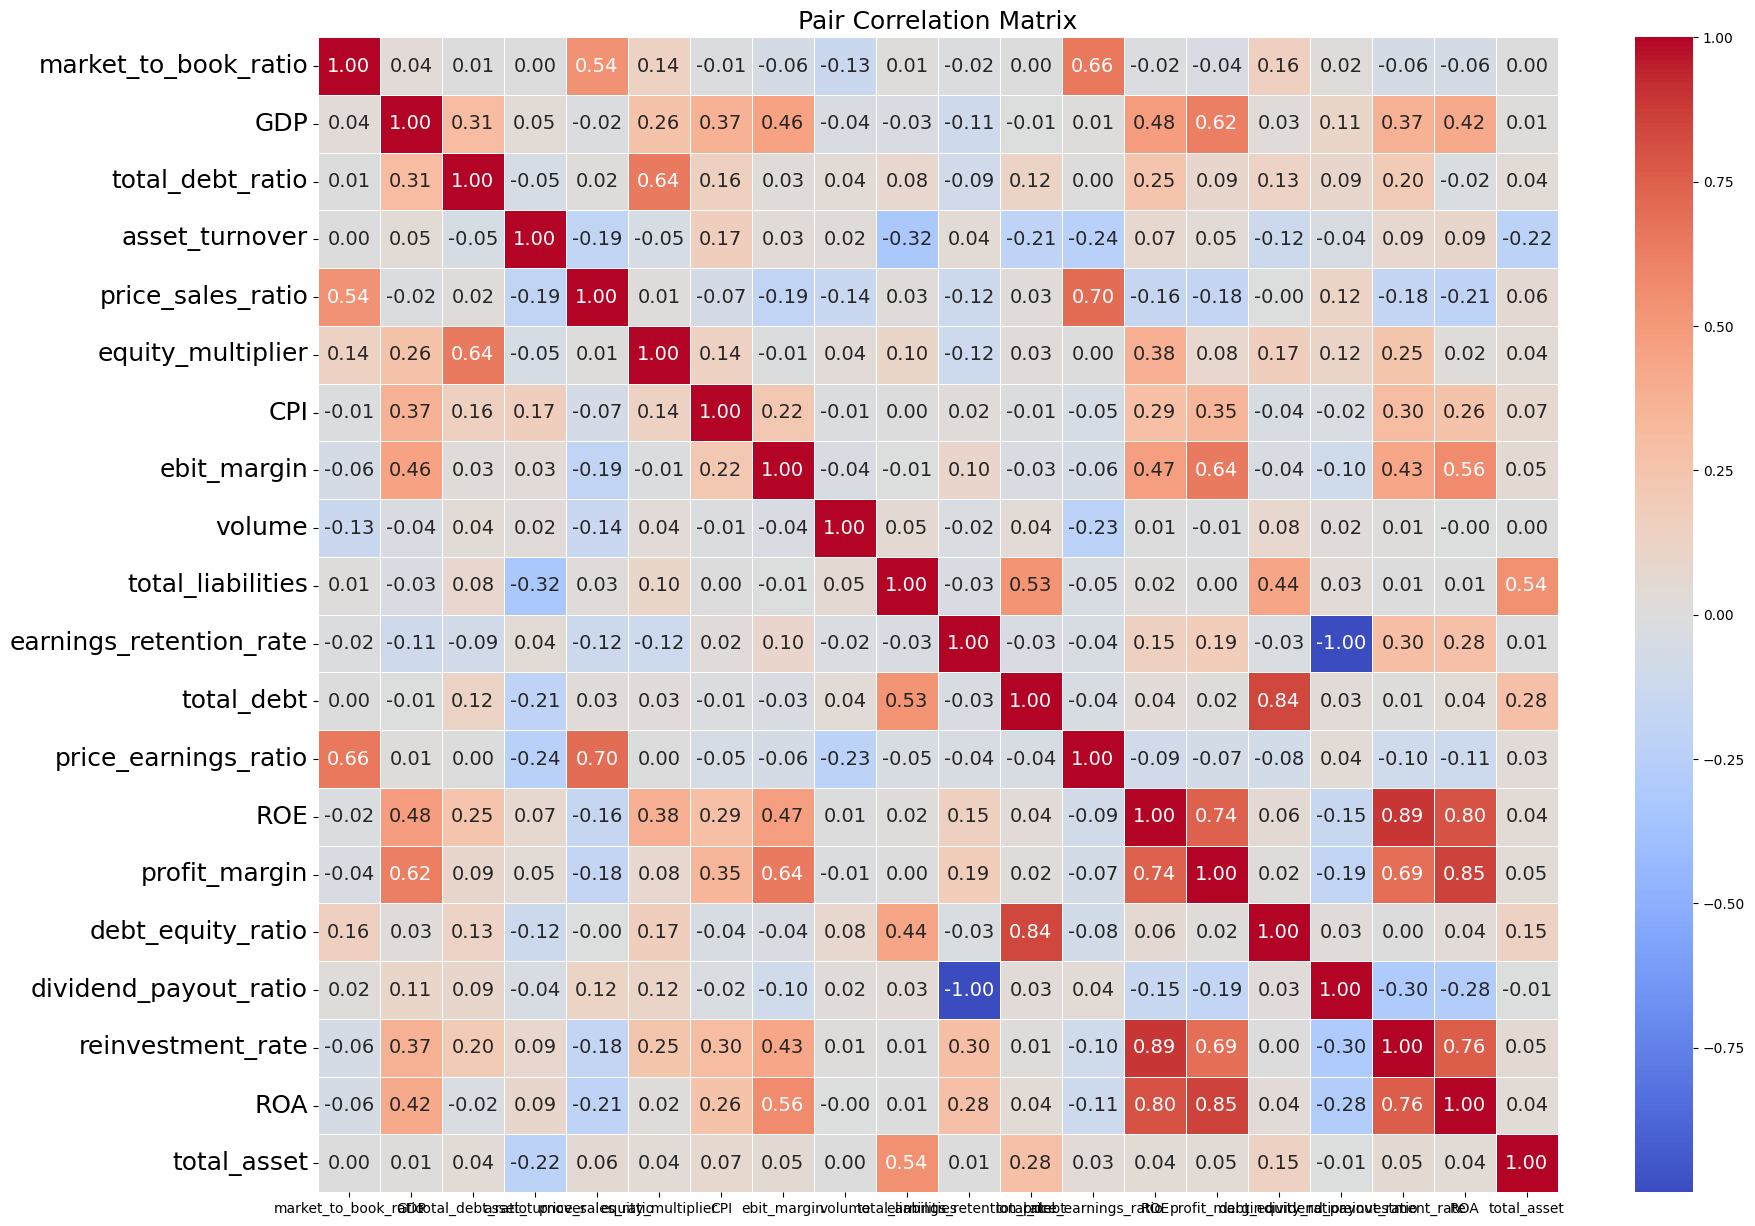

In [111]:
warnings.filterwarnings('ignore', category=RuntimeWarning)
display(calculate_vif(unified_dataset, INITIAL_FEATURES))
plot_pair_corr_heatmap(unified_dataset[INITIAL_FEATURES], unified_dataset[INITIAL_FEATURES].columns)
warnings.resetwarnings()

#### Multicollinearity analysis & fFeatures selection

The following cell will filter the features accordingly to two parameters related to the VIF and Correlation score. It's also possible to manually specify a list of features to drop.

In [250]:
# Initial available features - Scores for all features are shown in cell above
mlt_dataset = unified_dataset[INITIAL_FEATURES]
print(f'Initial available Features: \n')
print_list_as_table(INITIAL_FEATURES,6)

# This part drops feature with VIF > 5, Correlation > 0.6
mlt_dataset, features, dropped = automatic_multicollinearity_analysis(mlt_dataset, 
                                                                      features = INITIAL_FEATURES,
                                                                      corr_tr = 0.5, 
                                                                      vif_tr = 10)
# Remaining features
print(f'\nManual feature reduction:')
MANUAL_DROP = ['earnings_retention_rate','ebit_margin','GDP'] # From the pvalue info after model training

# Choose columns to drop accordingly to VIF and Correlation
mlt_dataset = mlt_dataset.drop(columns = MANUAL_DROP, axis = 1)
FEATURES = list(set(e for e in mlt_dataset.columns.tolist()))
vifs = calculate_vif(mlt_dataset, FEATURES)

print(f' - Manual Dropped Columns: {MANUAL_DROP}\n')
print(f'Final Used Features:\n')
print_list_as_table(FEATURES,6)
display(vifs.round(1), f'\nVariance Inflation Index')
plot_pair_corr_heatmap(mlt_dataset, mlt_dataset.columns)

Initial available Features: 

+----------------------+-------------+------------------+-------------------+-------------------------+-------------------+
| market_to_book_ratio | GDP         | total_debt_ratio | asset_turnover    | price_sales_ratio       | equity_multiplier |
+----------------------+-------------+------------------+-------------------+-------------------------+-------------------+
| CPI                  | ebit_margin | volume           | total_liabilities | earnings_retention_rate | total_debt        |
+----------------------+-------------+------------------+-------------------+-------------------------+-------------------+
| price_earnings_ratio | ROE         | profit_margin    | debt_equity_ratio | dividend_payout_ratio   | reinvestment_rate |
+----------------------+-------------+------------------+-------------------+-------------------------+-------------------+
| ROA                  | total_asset |                  |                   |                         

Features  VIF
0  market_to_book_ratio  1.0
1      total_debt_ratio  1.1
2        asset_turnover  1.2
3                   ROE  1.1
4                   CPI  1.1
5                volume  1.0
6     total_liabilities  1.1

'\nVariance Inflation Index'

### Charts of downloaded companies

Section to display a chart for each company of the prepared dataset. Actually is showing a line for each chosen feature only.

In [251]:
# List of total possible available columns name of the dataset to display. Now it display only the selected features.
LINES = [
    'close', 
     'volume', 
     'total_liabilities', 
     'ebit_margin', 
     'total_asset', 
     'total_debt', 
     'debt_equity_ratio', 
     'equity_multiplier', 
     'total_debt_ratio',
     'asset_turnover', 
     'reinvestment_rate', 
     'ROE', 
     'ROA', 
     'profit_margin', 
     'price_earnings_ratio', 
     'market_to_book_ratio', 
     'price_sales_ratio', 
     'GDP', 
     'CPI', 
     'BinaryClose'
        ]

plot_all_companies(unified_dataset, labels = FEATURES)

### Creation of lagged version of the dataset

In this cell is performed the last preparation step. The dataset is modified and duplicated accordingly to the requested number of lags of the dataset.

In [252]:
LAGS = 4 # Requested Lags
lagged_dataset = create_lags(unified_dataset.copy(), LAGS )

print(f'Lagged Dataset Created - Lag keys: {list(lagged_dataset.keys())}')

Lagged Dataset Created - Lag keys: [1, 2, 3, 4]


### Econometric analysis

In this analysis a Logit model is trained using the created dataset.

#### Model training & scores

In [253]:
SPLITS = 4 # Number of splits for the cross-validation
print(f'Start Training ... ')

scores_lr, models_lr, cms_lr = train_logit(lagged_dataset, DEPENDENT_VARIABLE_LB, FEATURES, splits = SPLITS)
print('Trained!')
# Logistic Regression Scores ------------------------------------------------------------------------------------------------------------------------
print(f'\nLogit Model - Training results')

print_results_heatmap(
    scores_lr.groupby('Lag').mean().sort_values(by = ['Accuracy','Precision','AUROC','Recall'], ascending = False).drop('Split', axis = 1), 
    title = 'Lag Level Avg Scores', 
    avoid_cols = ['Split','Lag'],
    inv_pattern_cols = [f'p_val({e})' for e in FEATURES],
    range_01_cols = [f'p_val({e})' for e in FEATURES]
)

print_results_heatmap(
    scores_lr.round(3).sort_values(by = ['Accuracy','Precision','AUROC','Recall'], ascending = False), 
    title = 'Split Level Scores', 
    avoid_cols = ['Split','Lag'],
    inv_pattern_cols = [f'p_val({e})' for e in FEATURES],
    range_01_cols = [f'p_val({e})' for e in FEATURES]
)
 
print('\nConfusion Matrixes\n')
print_confusion_matrixes(cms_lr, LAGS, SPLITS)

Start Training ... 
Trained!

Logit Model - Training results
Lag Level Avg Scores


Split Level Scores



Confusion Matrixes



#### Model Predictions

This section provide a prediction for the next future quarter of the previously chosen tester.

In [254]:
# to change tester re run all cells from 'Lag and Time Series KFold Parameters'
display(selected_companies.loc[selected_companies.index == tester_id]) # Tester Details
predict_next_quarter_returns(models_lr, TESTER, FEATURES, LAGS, SPLITS)

Company                       Country       Date       Sector  \
Identifier                                                                     
FDX.N       FedEx Corp  United States of America(US) 1978-12-28  Industrials   

           Country Code        Income  
Identifier                             
FDX.N                US  1.140834e+09

'Prediction for quarter successive to:'

Company     close    volume  total_liabilities  ebit_margin  \
Date                                                                     
2023-06-30   FDX.N  0.244614  0.211139          -0.355585      0.41727   

            total_asset  total_debt  debt_equity_ratio  equity_multiplier  \
Date                                                                        
2023-06-30    -0.202723   -0.088793          -0.264246           1.365732   

            total_debt_ratio  ...       ROA  profit_margin  \
Date                          ...                            
2023-06-30          0.602233  ... -0.248797       0.551043   

            price_earnings_ratio  market_to_book_ratio  price_sales_ratio  \
Date                                                                        
2023-06-30              0.476651             -0.020631           -0.51747   

            dividend_payout_ratio  earnings_retention_rate       GDP  \
Date                                                                   
2023-06-30               0.736186                -0.736186  1.652573   

                 CPI  BinaryClose  
Date                               
2023-06-30  3.322322            1  

[1 rows x 23 columns]

### Neural network analysis

#### Model training & score

Start Training:


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:47<00:00,  6.72s/it]


MLP Model - Training results
Lag Level Scores


Split Level Scores



Confusion Matrixes



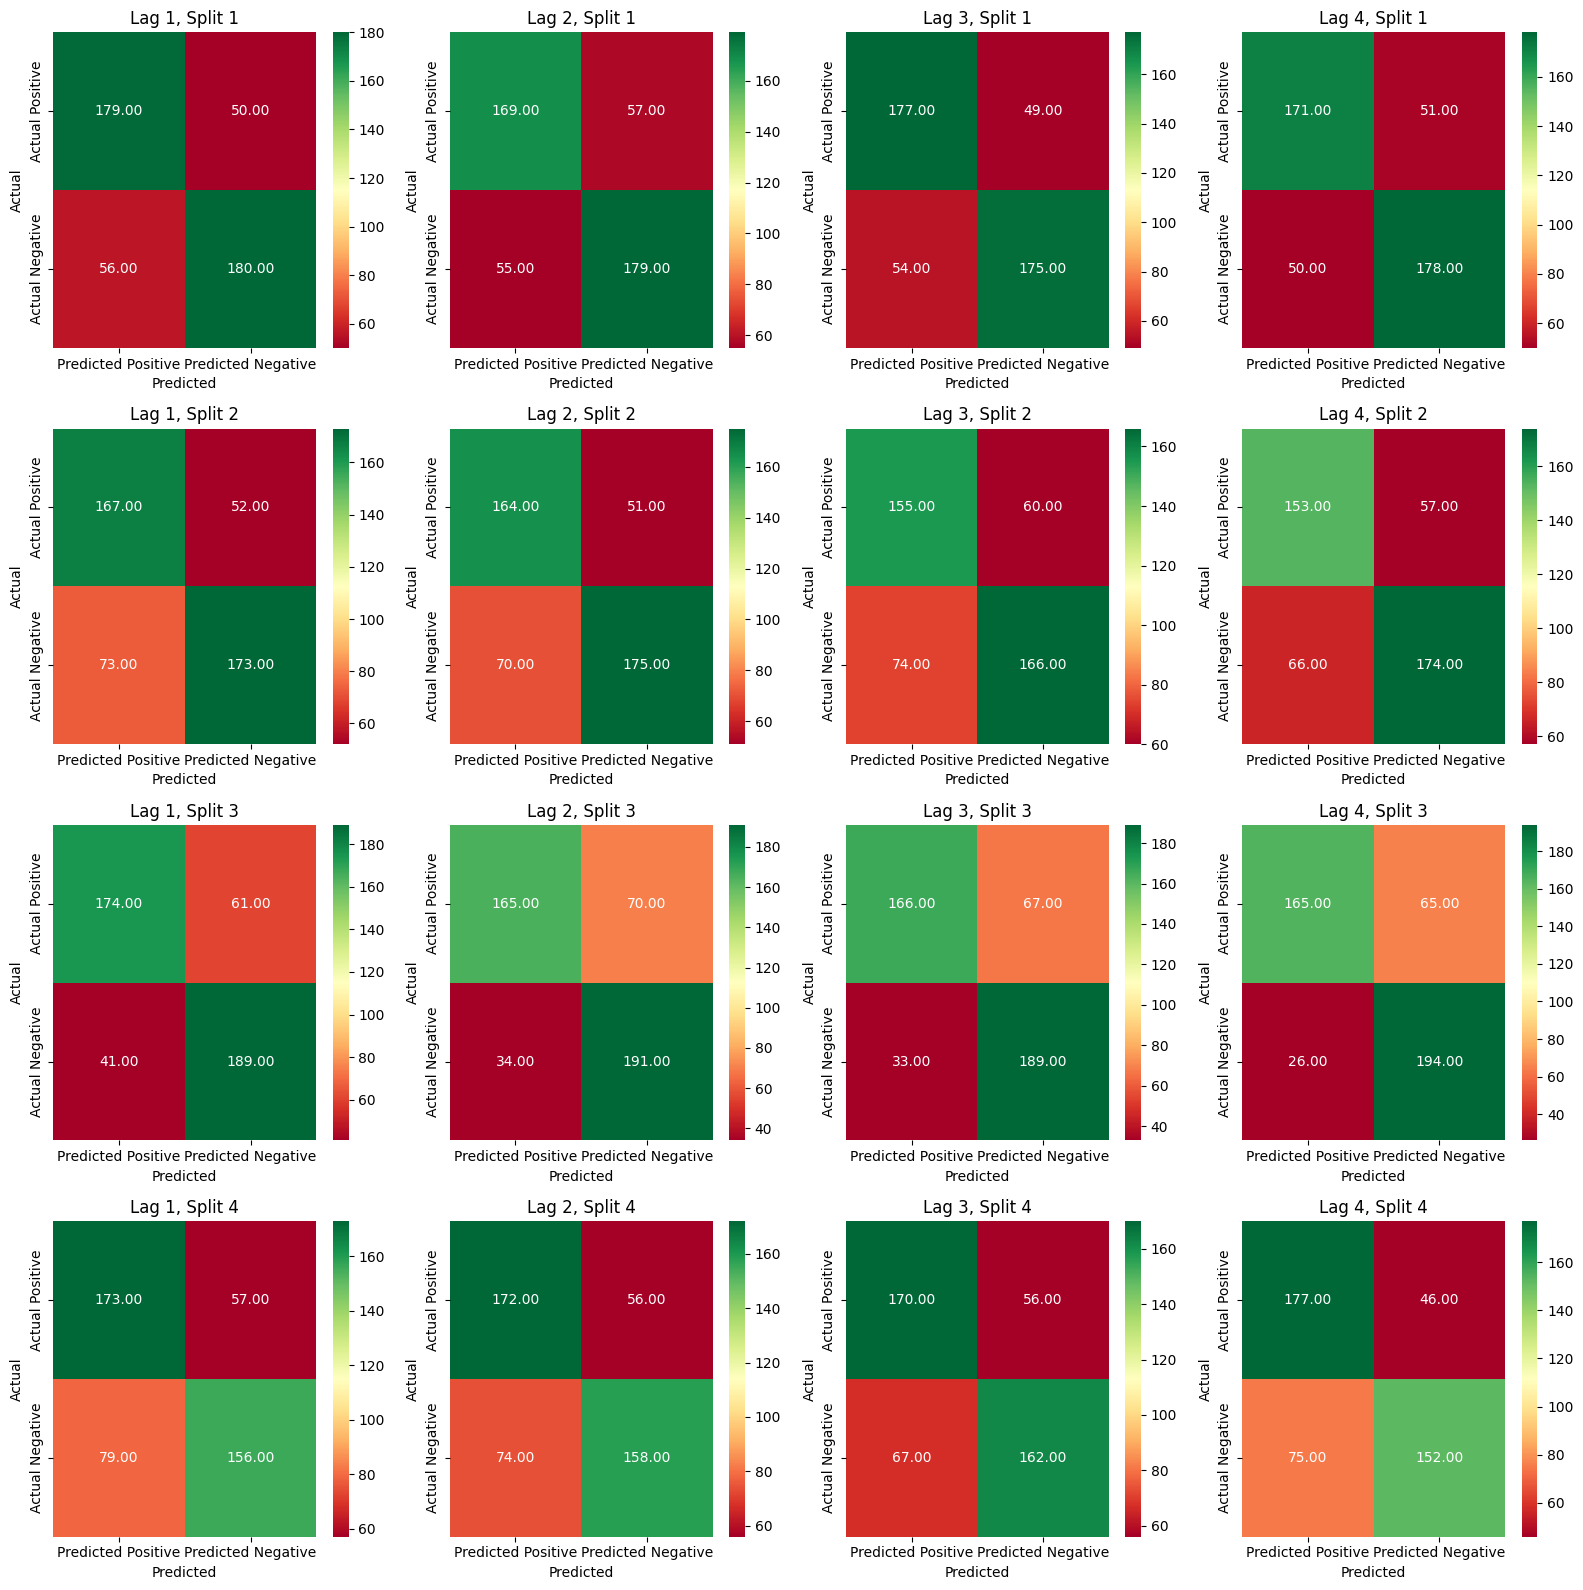

In [255]:
print(f'Start Training:')

scores_mlp, models_mlp, cms_mlp = train_mlp(lagged_dataset, DEPENDENT_VARIABLE_LB, FEATURES, splits = SPLITS)

# Logistic Regression Scores
print(f'\nMLP Model - Training results')
print_results_heatmap(scores_mlp.groupby('Lag').max().sort_values(by = ['Accuracy','Precision','AUROC','Recall'], ascending = False).drop('Split', axis = 1), title = 'Lag Level Scores', avoid_cols = ['Split','Lag'],    inv_pattern_cols = [f'p_val({e})' for e in FEATURES],
    range_01_cols = [f'p_val({e})' for e in FEATURES])
print_results_heatmap(
    scores_mlp.sort_values(by = ['Accuracy','Precision','AUROC','Recall'], ascending = False), 
    title = 'Split Level Scores', 
    avoid_cols = ['Split','Lag'],
    inv_pattern_cols = [f'p_val({e})' for e in FEATURES],
    range_01_cols = [f'p_val({e})' for e in FEATURES]
)
 
print('\nConfusion Matrixes\n')
print_confusion_matrixes(cms_mlp, LAGS, SPLITS)

#### Model Prediction

This section provide a prediction for the next future quarter of the previously chosen tester.

In [256]:
display(selected_companies.loc[selected_companies.index == tester_id]) # Tester Details
predict_next_quarter_returns(models_mlp, TESTER, FEATURES, LAGS, SPLITS)

Company                       Country       Date       Sector  \
Identifier                                                                     
FDX.N       FedEx Corp  United States of America(US) 1978-12-28  Industrials   

           Country Code        Income  
Identifier                             
FDX.N                US  1.140834e+09

'Prediction for quarter successive to:'

Company     close    volume  total_liabilities  ebit_margin  \
Date                                                                     
2023-06-30   FDX.N  0.244614  0.211139          -0.355585      0.41727   

            total_asset  total_debt  debt_equity_ratio  equity_multiplier  \
Date                                                                        
2023-06-30    -0.202723   -0.088793          -0.264246           1.365732   

            total_debt_ratio  ...       ROA  profit_margin  \
Date                          ...                            
2023-06-30          0.602233  ... -0.248797       0.551043   

            price_earnings_ratio  market_to_book_ratio  price_sales_ratio  \
Date                                                                        
2023-06-30              0.476651             -0.020631           -0.51747   

            dividend_payout_ratio  earnings_retention_rate       GDP  \
Date                                                                   
2023-06-30               0.736186                -0.736186  1.652573   

                 CPI  BinaryClose  
Date                               
2023-06-30  3.322322            1  

[1 rows x 23 columns]